# Projet naiades

par Charlotte Kruzic & Zoé Marquis

UE Entreposage et protection des données

Quel lien peut-on établir entre la physico-
chimie de l’eau et son état biologique ?

## TODO ZOE CHARLOTTE : 
Le problème posé. Le sujet est volontairement ouvert, il est nécessaire de bien cadrer la question
que l’on se pose, d’identifier les limites imposées et celles que vous décidez d’ajouter.

- reprendre dans le sujet les différentes contraintes
- puis formuler notre problématique 

une liste en dessous : 

- Comment l'évolution temporelle d'un paramètre physico-chimique spécifique (par exemple, les nitrates) affecte-t-elle l'état biologique de l'eau, et peut-on caractériser cette relation à l'aide de techniques de clustering?
- Un modèle de régression peut-il prédire avec précision l'indice biologique (I2M2) à partir des paramètres physico-chimiques, et si oui, quelles sont les implications pour la gestion et la surveillance de l'eau?
- Comment les variations spatiales des paramètres physico-chimiques et des indices biologiques diffèrent-elles entre les hydroécorégions de France, et quelles informations peut-on tirer de la comparaison de ces modèles avec les données géographiques?
- Comment les événements exceptionnels et les cycles saisonniers influencent-ils la relation entre les paramètres physico-chimiques et les indices biologiques, et quelles stratégies peuvent être employées pour prendre en compte ces facteurs dans les efforts de gestion et de surveillance de l'eau?

- pn pourra revoir toute la démarche pour chercher une problématique assez ciblé sur ce qu'on a fait

In [1]:
import geopandas as gpd

from matplotlib.patches import Patch
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import zscore

import shapely.geometry as geom

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import zstandard as zstd

## Chargement des données

In [2]:
# stations
df_load_stations = pd.read_csv('data/stations_hb.csv.zst',sep=';',escapechar = '\\')
df_stations = df_load_stations.copy() # copy pour nettoyer etc mais garder l'original pour recouperer les infos

In [3]:
# pc : physicochimie
f="data/donnees_physicochimie.csv.zst"
pc_sample = pd.read_csv(f,nrows=1)
pc_list_cols = pc_sample.columns
pc_list_cat = pc_list_cols[pc_list_cols.str.startswith((
    'Lb','Nom','Mnemo',
    'Cd','Sym','Com'))]

pc_dict_cat = {col: 'category' for col in pc_list_cat}

df_load_pc = pd.read_csv(
        f,
        sep=',',
        engine='c',
        escapechar='\\',
        dtype=pc_dict_cat,
        parse_dates=[7],
        iterator=False)
df_pc = df_load_pc.copy()

In [4]:
# hydrobio
df_load_hydrobio = pd.read_csv('data/donnees_hydrobio.csv.zst',sep=',',escapechar = '\\')
df_hydrobio = df_load_hydrobio.copy()

In [5]:
# hydroecoregion
df_load_hydroregions = gpd.read_file("data/Hydroecoregion1-shp.zip")
df_hydroregions = df_load_hydroregions.copy()

## Analyse exploratoire

TODO ZOE rédiger : 
Objectif : que contient chaque dataset, identifier les colonnes à supprimer, comment remodeler les données...

### Données géographiques

In [6]:
df_stations.head(3)

,CdStationMesureEauxSurface,LbStationMesureEauxSurface,DurStationMesureEauxSurface,CoordXStationMesureEauxSurface,CoordYStationMesureEauxSurface,CdProjStationMesureEauxSurface,LibelleProjection,CodeCommune,LbCommune,CodeDepartement,...,DateMAJInfosStationMesureEauxSurface,FinaliteStationMesureEauxSurface,LocPreciseStationMesureEauxSurface,CodeNatureStationMesureEauxSurface,LibelleNatureStationMesureEauxSurface,AltitudePointCaracteritisque,PkPointTronconEntiteHydroPrincipale,PremierMoisAnneeEtiage,SuperficieBassinVersantReel,SuperficieBassinVersantTopo
0,01000477,LA SLACK À RINXENT (62),NaN,610228.78,7078879.90,26,RGF93 / Lambert 93,62711,RINXENT,62,...,2015-12-14 00:00:00,NaN,Lieu-dit Ferme du Château. La Planche du Devin,M,Station de mesure Manuelle,0.0,980.48,6.0,NaN,0.0
1,01000602,COLOGNE à BUIRE COURCELLES (80),NaN,700318.40,6980033.60,26,RGF93 / Lambert 93,80150,BUIRE-COURCELLES,80,...,2015-12-14 00:00:00,NaN,MOULIN DE BINARD PONT D 194 E,M,Station de mesure Manuelle,0.0,992.58,6.0,NaN,0.0
2,01000605,L'OMIGNON À DEVISE (80),NaN,700279.85,6973284.26,26,RGF93 / Lambert 93,80239,DEVISE,80,...,2015-12-14 00:00:00,NaN,ROUTE DE L'EGLISE,M,Station de mesure Manuelle,0.0,993.69,6.0,NaN,0.0


La table station est utile pour situer les stations ainsi que pour extraire l'identifiant pour joindre les tables sur les stations.

In [7]:
df_hydroregions.head(3)

,gid,CdHER1,NomHER1,geometry
0,1,16,CORSE,"POLYGON ((9.43319 43.00468, 9.4357 42.99999, 9..."
1,2,12,ARMORICAIN,"POLYGON ((-2.61068 48.55022, -2.61268 48.54898..."
2,3,13,LANDES,"MULTIPOLYGON (((-1.04228 45.54443, -1.03836 45..."


In [8]:
# On vérifie qu'on a bien un CdHER1 pour un NomHER1
print(df_hydroregions['CdHER1'].value_counts())

CdHER1
16    1
12    1
13    1
14    1
1     1
11    1
21    1
2     1
7     1
20    1
18    1
4     1
15    1
8     1
19    1
5     1
6     1
17    1
3     1
9     1
10    1
22    1
Name: count, dtype: int64


On a bien 1 CdHER1 pour 1 NomHER1, donc on va afficher la carte avec NomHER1 car cela est plus parlant pour l'utilisateur.

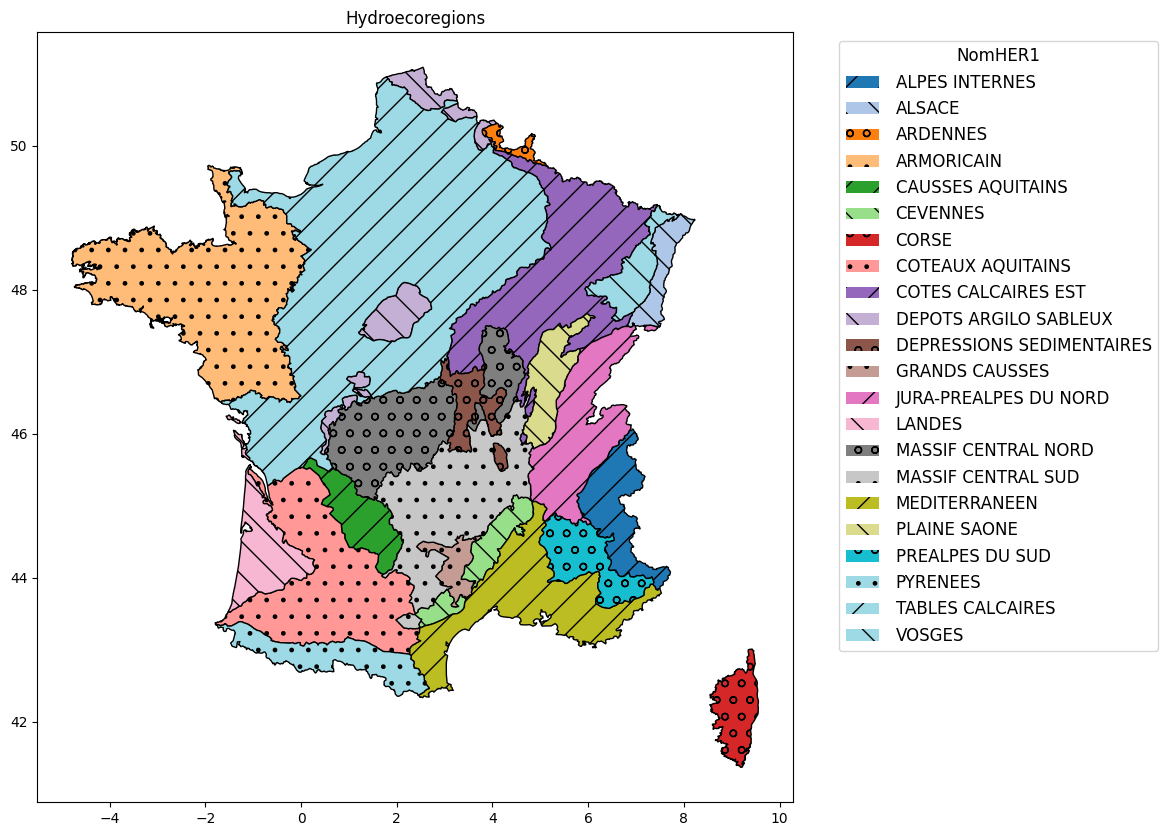

In [9]:
# Afficher les hydroeco regions

fig, ax = plt.subplots(figsize=(20, 10))

colors = plt.colormaps['tab20']
hatches = ['/', '\\', 'o', '.']
legend_elements = []

for i, (name, region) in enumerate(df_hydroregions.groupby('NomHER1')):
    patch = region.plot(ax=ax, color=colors(i), hatch=hatches[i % len(hatches)], edgecolor='black', label=name)
    legend_elements.append(Patch(facecolor=colors(i), hatch=hatches[i % len(hatches)], label=name))

ax.set_title('Hydroecoregions')

ax.legend(handles=legend_elements, title='NomHER1', bbox_to_anchor=(1.05, 1), loc='upper left',  fontsize='large', title_fontsize='large', handletextpad=1)

plt.show()


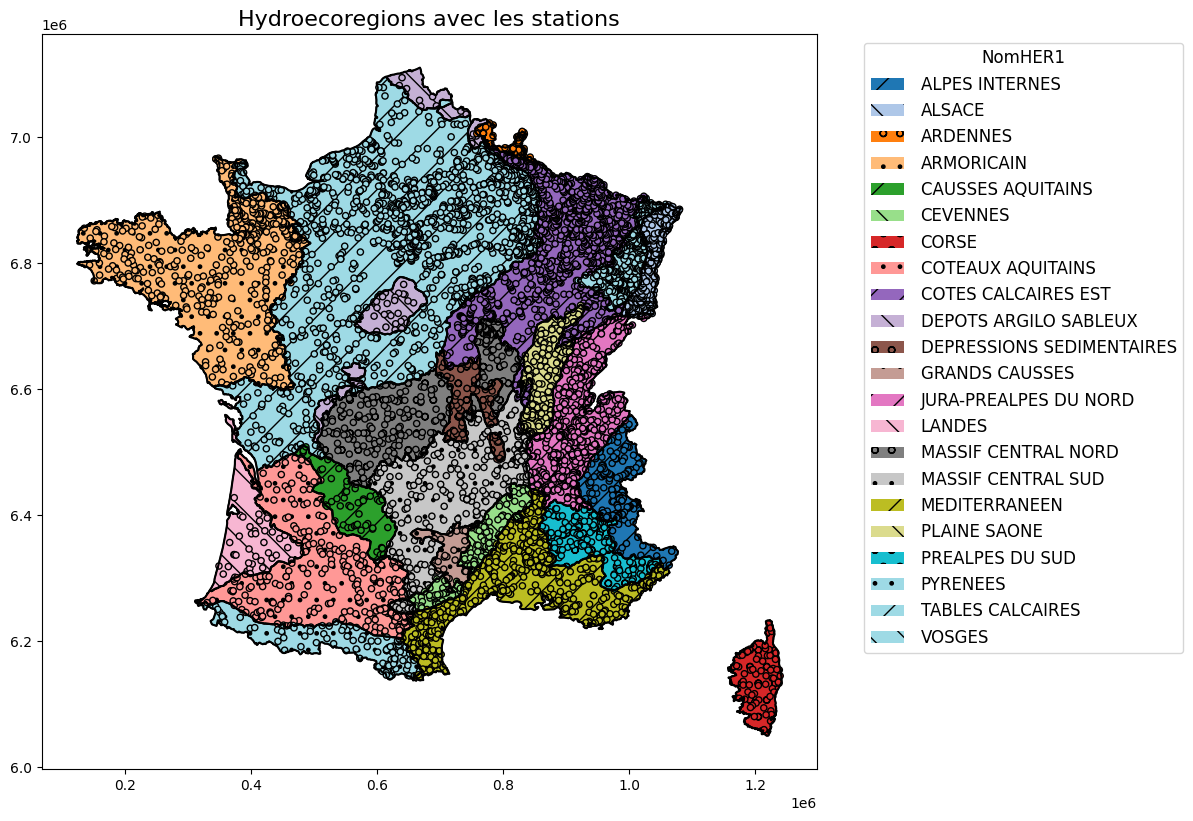

In [10]:
# Situons les différentes stations de la table station dans la carte des hydroecoregions

# TODO CHARLOTTE OK : mettre la bonne forme de projection avec la bonne couleur pour les stations comme la cellule juste au dessus 

crs_lambert = 'PROJCS["RGF_1993_Lambert_93",GEOGCS["GCS_RGF_1993",DATUM["D_RGF_1993",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",700000.0],PARAMETER["False_Northing",6600000.0],PARAMETER["Central_Meridian",3.0],PARAMETER["Standard_Parallel_1",49.0],PARAMETER["Standard_Parallel_2",44.0],PARAMETER["Latitude_Of_Origin",46.5],UNIT["Meter",1.0]]'
x_col = 'CoordXStationMesureEauxSurface'
y_col = 'CoordYStationMesureEauxSurface'
carto_i2m2 = gpd.GeoDataFrame(df_stations,crs=crs_lambert ,
                        geometry = gpd.GeoSeries(df_stations.agg(lambda x:geom.Point(x.loc[x_col],x.loc[y_col])  ,axis=1)))

HER_stations=carto_i2m2.sjoin(df_hydroregions.to_crs(crs_lambert),predicate='within').to_crs(crs_lambert)

fig, ax = plt.subplots(1, 1, figsize=(10, 30))

colors = plt.colormaps['tab20']
hatches = ['/', '\\', 'o', '.']
legend_elements = []

color_mapping = {}
for i, (name, region) in enumerate(df_hydroregions.groupby('NomHER1')):
    region = region.to_crs(crs_lambert)
    patch = region.plot(ax=ax, color=colors(i), hatch=hatches[i % len(hatches)], edgecolor='black', label=name)
    legend_elements.append(Patch(facecolor=colors(i), hatch=hatches[i % len(hatches)], label=name))
    color_mapping[name] = colors(i)

station_colors = HER_stations['NomHER1'].map(color_mapping)
HER_stations.plot(ax=ax, color=station_colors, markersize=20, edgecolor='black')

HER_lambert = df_hydroregions.to_crs(crs_lambert)
HER_lambert.boundary.plot(ax=ax, color='black')

ax.legend(handles=legend_elements, title='NomHER1', bbox_to_anchor=(1.05, 1), loc='upper left',  fontsize='large', title_fontsize='large', handletextpad=1)
ax.set_title('Hydroecoregions avec les stations', fontsize=16)

plt.show()


### Données physico-chimiques et hydrobiologiques

In [11]:
df_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8917443 entries, 0 to 8917442
Data columns (total 49 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   CdStationMesureEauxSurface  category      
 1   LbStationMesureEauxSurface  category      
 2   CdSupport                   category      
 3   LbSupport                   category      
 4   CdFractionAnalysee          category      
 5   LbFractionAnalysee          category      
 6   CdPrelevement               category      
 7   DatePrel                    datetime64[ns]
 8   HeurePrel                   object        
 9   CdParametre                 category      
 10  LbLongParamètre             category      
 11  RsAna                       float64       
 12  CdUniteMesure               category      
 13  SymUniteMesure              category      
 14  CdRqAna                     category      
 15  MnemoRqAna                  category      
 16  CdInsituAna       

In [12]:
df_pc.shape

(8917443, 49)

In [13]:
df_hydrobio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43535 entries, 0 to 43534
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          43535 non-null  int64  
 1   CdStationMesureEauxSurface          43535 non-null  int64  
 2   LbStationMesureEauxSurface          43535 non-null  object 
 3   CdPointEauxSurf                     43115 non-null  float64
 4   DateDebutOperationPrelBio           43535 non-null  object 
 5   CdSupport                           43535 non-null  int64  
 6   LbSupport                           43535 non-null  object 
 7   DtProdResultatBiologique            14829 non-null  object 
 8   CdParametreResultatBiologique       43535 non-null  int64  
 9   LbLongParametre                     43535 non-null  object 
 10  ResIndiceResultatBiologique         43522 non-null  float64
 11  CdUniteMesure                       43535

In [14]:
df_hydrobio.shape

(43535, 21)

# TODO ZOE reformuler 
on sait dans nos contraintes qu'on doit utiliser les données temporelles et spatiales

nous on aimerait utiliser les données temporelles et voir si on arrive à faire un clustering pour retrouver les hydroecoregions

pour exploiter la relation entre physico chimie et hydrobiologique on se doute que pc a un impact sur hydrobio

on voit bien qu'on a presqeu 9 millions de données pc

on va donc devoir nettoyer beaucoup ces données pour réduire pn a pas des machines super puissante
supprimer duplicatas, les données aberrantes
ce qui va etre challengeant car il y a tellement de données qu'on ne peut pas non plus beaucoup plot, donc on va devoir mettre en place des sytratégies pour supprimer sans perdre d'information

on va agréger déjà par saison par année les données par station

on va étudier quelles parametres / support / fraction / unité de mesure sont étudiés

on va pivoter pour enfaite obtenir une table qui 
par station, par saison par année, par paramètre intéressant de pc : médiane / moyenne des données (agréger suivant deux paramètres)

puis on va ajouter les données hydrobio

pour cela il faut donc faire la meme préparation
on pourrait utiliser lesvaleurs directement en agrégeant de la meme maniere
ou aussi les classes de l'url fourni dans l'énoncé

comme dit on pense que pc a un impact sur hydrobio
on va essayer différents laps de temps de décalage (1 mois, 3 mois, 6 mois) (à voir quand on aura fini)
pour voir si ça changebeaucoup la performance

ensuite joindre à notre table de pc plus legere agrégé nettoyé les données hydrobio
on ne garde que celle où c'est en commun avec station (on va utilser la table station pour join)

on fait un clustering sur le nombre de clusters de hydroecoregions (mais enfaite il faut qu'on véérifie une fois qu'on a join est ce qu'on a des données pour chaque hydroecoregions) si non on calcule quelle nombre on a ( on replot nos stations sur la map )

## Préparation des données physicochimiques

In [15]:
# combien de données dupliquéss ?
print(df_pc.duplicated().sum())

11836


In [16]:
# supprimer les doublons
df_pc.drop_duplicates(inplace=True)

## TODO ZOE : Notes sur les colonne à conserver
on émet l'hypothese que le laboratoire, le producteur, le préleveur et le rdd ne sont pas des données de pc, 
enfaite sur le nombre total de colonnes on va en garder tres peu

on pense que beauoup de données sobnt des metadonnées / 
on pense qu'ils sont censés pour un meme prelevement avoir les memes valeurs  
ce sont plutot des metadonnées sur le prelevement, on ne les prends pas en compte dans notre analyse  

puisqu'on va agréger par saison, on ne gardera pas non plus la colonne heure

## Caractériser une analyse physico chimique

Comme vu dans le TD, ce qui caractérise une analyse c'est : 
- le support
- le paramètre
- la fraction analysée
- dans quelle unité

In [17]:
print("Supports :", df_pc['LbSupport'].nunique(), "valeurs ->", df_pc['LbSupport'].unique().tolist())
print("Paramètres :", df_pc['LbLongParamètre'].nunique(), "valeurs ->", df_pc['LbLongParamètre'].unique().tolist())
print("Fractions :", df_pc['LbFractionAnalysee'].nunique(), "valeurs ->", df_pc['LbFractionAnalysee'].unique().tolist())
print("Unités :", df_pc['SymUniteMesure'].nunique(), "valeurs ->", df_pc['SymUniteMesure'].unique().tolist())

Supports : 5 valeurs -> ['Eau', 'Air', 'Sédiments', 'Diatomées benthiques', 'Gammares']
Paramètres : 16 valeurs -> ['Matières en suspension', 'Demande Biochimique en oxygène en 5 jours (D.B.O.5)', "Température de l'Eau", 'Potentiel en Hydrogène (pH)', 'Conductivité à 25°C', 'Oxygène dissous', 'Taux de saturation en oxygène', 'Phosphore total', 'Turbidité Formazine Néphélométrique', 'Azote Kjeldahl', 'Diuron', 'Carbone Organique', 'Ammonium', 'Nitrites', 'Nitrates', 'Orthophosphates (PO4)']
Fractions : 2 valeurs -> ['Eau brute', "Phase aqueuse de l'eau (filtrée, centrifugée...)"]
Unités : 15 valeurs -> ['mg/L', 'mg(O2)/L', '°C', 'unité pH', 'µS/cm', '%', 'mg(P)/L', 'NFU', 'mg(N)/L', 'µg/L', 'mg(C)/L', 'mg(NH4)/L', 'mg(NO2)/L', 'mg(NO3)/L', 'mg(PO4)/L']


On va analyser combien de parametres par fraction pr support par unité de mesure on a 

# TODO ZOE : reformuler

#### Fractions et Supports

In [18]:
test = df_pc[['LbSupport','LbFractionAnalysee']].drop_duplicates()

In [19]:
print('Nombre de fractions par support')
test.groupby(['LbSupport']).count()

Nombre de fractions par support


,LbFractionAnalysee
LbSupport,
Eau,2
Air,2
Sédiments,2
Diatomées benthiques,1
Gammares,1


Pour un support donné plusieurs fractions peuvent être analysées.

In [20]:
print('Nombre de supports par fraction')
test.groupby(['LbFractionAnalysee']).count()

Nombre de supports par fraction


,LbSupport
LbFractionAnalysee,
Eau brute,5
"Phase aqueuse de l'eau (filtrée, centrifugée...)",3


Pour une fraction donnée plusieurs supports peuvent être analysés.

#### Fractions et paramètres

In [21]:
test = df_pc[['LbLongParamètre','LbFractionAnalysee']].drop_duplicates()

In [22]:
print('Nombre de fractions par paramètre')
test.groupby(['LbLongParamètre']).count()

Nombre de fractions par paramètre


,LbFractionAnalysee
LbLongParamètre,
Azote Kjeldahl,1
Conductivité à 25°C,1
Demande Biochimique en oxygène en 5 jours (D.B.O.5),1
Diuron,1
Matières en suspension,1
Oxygène dissous,1
Phosphore total,1
Potentiel en Hydrogène (pH),1
Taux de saturation en oxygène,1


Pour un paramètre donné un seul type de fraction est analysé.

In [23]:
print('Nombre de paramètres par fraction')
test.groupby(['LbFractionAnalysee']).count()

Nombre de paramètres par fraction


,LbLongParamètre
LbFractionAnalysee,
Eau brute,11
"Phase aqueuse de l'eau (filtrée, centrifugée...)",5


Pour une fraction donnée plusieurs paramètres peuvent être analysés.

#### Supports et paramètres

In [24]:
test = df_pc[['LbLongParamètre','LbSupport']].drop_duplicates()

In [25]:
print('Nombre de supports par paramètre')
test.groupby(['LbLongParamètre']).count()

Nombre de supports par paramètre


,LbSupport
LbLongParamètre,
Azote Kjeldahl,3
Conductivité à 25°C,4
Demande Biochimique en oxygène en 5 jours (D.B.O.5),3
Diuron,3
Matières en suspension,3
Oxygène dissous,4
Phosphore total,3
Potentiel en Hydrogène (pH),5
Taux de saturation en oxygène,4


Pour un paramètre donné plusieurs supports peuvent être utilisés.

In [26]:
print('Nombre de paramètres par support')
test.groupby(['LbSupport']).count()
# 

Nombre de paramètres par support


,LbLongParamètre
LbSupport,
Eau,16
Air,14
Sédiments,14
Diatomées benthiques,2
Gammares,5


Pour un support donné plusieurs paramètres peuvent être analysés.

#### Unités de mesure et paramètres

In [27]:
test = df_pc[['LbLongParamètre','SymUniteMesure']].drop_duplicates()

In [28]:
print("Nombre d'unités par paramètre")
test.groupby(['LbLongParamètre']).count()

Nombre d'unités par paramètre


,SymUniteMesure
LbLongParamètre,
Azote Kjeldahl,1
Conductivité à 25°C,1
Demande Biochimique en oxygène en 5 jours (D.B.O.5),1
Diuron,1
Matières en suspension,1
Oxygène dissous,1
Phosphore total,1
Potentiel en Hydrogène (pH),1
Taux de saturation en oxygène,1


TODO Zoé : (charlotte) je pense que c'est 1 unité mais je te laisse faire si jamais mdrr  
Pour un paramètre donné plusieurs unités une seule unité de mesure est utilisée.

In [29]:
print("Nombre de paramètres par unité")
test.groupby(['SymUniteMesure']).count()

Nombre de paramètres par unité


,LbLongParamètre
SymUniteMesure,
%,1
NFU,1
mg(N)/L,1
mg(O2)/L,2
mg(P)/L,1
mg/L,1
unité pH,1
°C,1
µS/cm,1


Pour une unité de mesure donnée plusieurs paramètres peuvent être analysés.

# TODO ZOE reformuler : 
### Quelles informations en extraire ?
on a pour chaque parametre analysé seulement une unité de mesure  
-> pas besoin de nettoyer ou de garder la colonne unité une fois qu'on aura basculer dans notre dataframe pour l'analyse

D'après les diapos 

Un résultat d’analyse (RsAna) se caractérise
principalement par  
- Un paramètre physico-chimique (nitrate, phosphate,
température, pH…) (CdParametre)  
- Une unité de mesure (CdUniteMesure)  
- Une fraction d’analyse (CdFractionAnalysee) à
partir d’un support de prélèvement (CdSupport)

TODO Zoé : (charlotte) On voit juste au dessous que 1 unité est utilisé pour 2 paramètres, peut-être en parler ?  
Or ici on a vu qu'il n'y a qu'un paramètre par unité / une unité par paramètre.
On va donc basculer la table pour considérer pour chaque résultat d'analyse à la fois 
le paramètre, le support et la fraction.

In [30]:
# Pour un paramètre donné, combien y a t il d'unité de mesure, de support et de fraction analysee ?
print(df_pc.groupby('LbLongParamètre')['SymUniteMesure'].nunique().value_counts())
print(df_pc.groupby('LbLongParamètre')['LbSupport'].nunique().value_counts())
print(df_pc.groupby('LbLongParamètre')['LbFractionAnalysee'].nunique().value_counts())

SymUniteMesure
1    16
Name: count, dtype: int64
LbSupport
3    9
4    3
5    2
1    2
Name: count, dtype: int64
LbFractionAnalysee
1    16
Name: count, dtype: int64


On a aussi vu que pour un paramètre donné un seul type de fraction est analysé  
regardons la combinaison des triplets : 

## TODO ZOE reformuler

In [31]:
# Pour un paramètre et un support donné, combien de fraction différentes sont analysées ?   
grouped = df_pc.groupby(['LbLongParamètre','LbSupport'])['LbFractionAnalysee'].nunique()
multiple_fractions = grouped[grouped > 1]
print(multiple_fractions)

Series([], Name: LbFractionAnalysee, dtype: int64)


On a au maximum 1 fraction pour un paramètre et un support donné.

La fraction peut donc être déduit uniquement à partir du couple paramètre, support.

On va donc faire un regroupement par tuple **paramètre, support**

In [32]:
params = df_pc.groupby(["LbLongParamètre",'LbSupport'])

In [33]:
# nombre de valeurs pour chaque tuple
params.size().sort_values(ascending=False)

LbLongParamètre                LbSupport           
Potentiel en Hydrogène (pH)    Eau                     675940
Température de l'Eau           Eau                     675906
Conductivité à 25°C            Eau                     668744
Oxygène dissous                Eau                     632623
Taux de saturation en oxygène  Eau                     613947
                                                        ...  
Nitrates                       Gammares                     0
Nitrites                       Gammares                     0
                               Diatomées benthiques         0
Orthophosphates (PO4)          Diatomées benthiques         0
                               Gammares                     0
Length: 80, dtype: int64

In [34]:
# combien de résultats d'analyse pour chaque tuple ?
params_size = params.agg({'RsAna' : ['size']}) 

In [35]:
# regardons combien de lignes sont vides (RsAna = 0)
params_size[params_size[('RsAna','size')]==0]

RsAna
                                                                         size
LbLongParamètre                                    LbSupport                 
Azote Kjeldahl                                     Diatomées benthiques     0
                                                   Gammares                 0
Conductivité à 25°C                                Diatomées benthiques     0
Demande Biochimique en oxygène en 5 jours (D.B.... Diatomées benthiques     0
                                                   Gammares                 0
Diuron                                             Diatomées benthiques     0
                                                   Gammares                 0
Matières en suspension                             Diatomées benthiques     0
                                                   Gammares                 0
Oxygène dissous                                    Diatomées benthiques     0
Phosphore total                                    Diatomées benthiques     0
                                                   Gammares                 0
Taux de saturation en oxygène                      Diatomées benthiques     0
Turbidité Formazine Néphélométrique                Air                      0
                                                   Sédiments                0
                                                   Diatomées benthiques     0
                                                   Gammares                 0
Carbone Organique                                  Air                      0
                                                   Sédiments                0
                                                   Diatomées benthiques     0
                                                   Gammares                 0
Ammonium                                           Diatomées benthiques     0
                                                   Gammares                 0
Nitrates                                           Diatomées benthiques     0
                                                   Gammares                 0
Nitrites                                           Diatomées benthiques     0
                                                   Gammares                 0
Orthophosphates (PO4)                              Diatomées benthiques     0
                                                   Gammares                 0

In [36]:
params_size[params_size[('RsAna','size')]!=0].sort_values(('RsAna','size'),ascending=True)

,,RsAna
,,size
LbLongParamètre,LbSupport,
Conductivité à 25°C,Gammares,1
Taux de saturation en oxygène,Gammares,1
Potentiel en Hydrogène (pH),Gammares,1
Oxygène dissous,Gammares,1
Température de l'Eau,Gammares,1
Potentiel en Hydrogène (pH),Diatomées benthiques,28
Température de l'Eau,Diatomées benthiques,28
Diuron,Sédiments,35


# TODO ZOE rédiger
sur toutes les mesures, on voit qu'il n'y en a qu'une de Support Gammares 
38 de diatomées benthiques
et maximum 80 pour sédiments... 

en comparaison avec les milliers pour l'air, et les centaines de milliers de pour l'eau : 

on risque sous représentation de ces différents supports 

 stratégie possible : 
- over sampling 
- suppression (c'est ce qu'on fera plus tard : quand moins de 1 000 données pour un apramètre donnné -> on drop, ce qui créera moins de colonnes dans notre table pivot final)

In [37]:
# Conversion en chaînes de caractères de notre colonne caractérisant les paramètres (paramètre - support)
param_series = df_pc['LbLongParamètre'].astype(str) + ' - ' + df_pc['LbSupport'].astype(str)

### Traiter les seuils (de quantification, de saturation, de détection...)

In [38]:
df_pc[['CdRqAna','MnemoRqAna']].value_counts()

CdRqAna  MnemoRqAna                                                                    
1        Résultat > seuil de quantification et < au seuil de saturation ou Résultat = 0    7764758
10       Résultat < au seuil de quantification                                             1125177
0        Analyse non faite                                                                   10400
2        Résultat < seuil de détection                                                        3157
7        Traces (< seuil de quantification et > seuil de détection)                           1812
3        Résultat > seuil de saturation                                                        237
8        Dénombrement > Valeur                                                                  64
9        Dénombrement < Valeur                                                                   1
11       Echelle Absente                                                                         1
Name: count, dtype: i

d'après la doc : 
- 1 = ok : rien besoin de faire 
- 0 : analyse non faite -> le résultat doit être vide : nous on va supprimer ces lignes
- 2 : le résultat prend alors la valeur du seuil de détection ou du seuil de quantification suivant qu'il est inférieur à l'un de ces deux seuils : TODO le vérifier
- 3 : le résultat donne alors la valeur du seuil de saturation : TODO vérifier
- 7 : le résultat prend alors la valeur du seuil de détection ou du seuil de quantification suivant qu'il est inférieur à l'un de ces deux seuils. (comme 2) : TODO idem
- 8 : Les codes remarque 8 et 9 doivent être utilisés pour qualifier des résultats fournis par des méthodes de type qualitatif, décrits par rapport à un seuil bien que compris dans la plage d’utilisation courante des méthodes (supérieur au seuil de quantification et inférieur au seuil de saturation).
- 9 : Les codes remarque 8 et 9 doivent être utilisés pour qualifier des résultats fournis par des méthodes de type qualitatif, décrits par rapport à un seuil bien que compris dans la plage d’utilisation courante des méthodes (supérieur au seuil de quantification et inférieur au seuil de saturation).
TODO pour 8 et 9 : je sais pas ce qu'on est censé faire de cette info à part supprimer ces lignes 
- 10 : Le résultat quant à lui prend la valeur du seuil de quantification. : TODO vérifier mais rien besoin de faire
- 11 : pas de doc -> supprimer cette valeur

pour tous les TODO vérifier : on a pas besoin de modifier les valeurs 

In [39]:
print("Avant suppression:", df_pc.shape)
df_pc = df_pc[~df_pc['CdRqAna'].isin(['0', '8', '9', '11'])]
print("Après suppression:", df_pc.shape)
print(df_pc[['CdRqAna', 'MnemoRqAna']].value_counts())

Avant suppression: (8905607, 49)
Après suppression: (8895141, 49)
CdRqAna  MnemoRqAna                                                                    
1        Résultat > seuil de quantification et < au seuil de saturation ou Résultat = 0    7764758
10       Résultat < au seuil de quantification                                             1125177
2        Résultat < seuil de détection                                                        3157
7        Traces (< seuil de quantification et > seuil de détection)                           1812
3        Résultat > seuil de saturation                                                        237
Name: count, dtype: int64


In [40]:
# TODO ZOE : cellule pour vérifier 2, 3, 7, 10

In [41]:
# df_pc_light : pour un parametre/support donné, un résultat d'analyse à une date donnée
df_pc_light = df_pc[['CdStationMesureEauxSurface','DatePrel','RsAna']] 
df_pc_light['param'] = param_series
df_pc_light 

C:\Users\charl\AppData\Local\Temp\ipykernel_19348\3583793383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pc_light['param'] = param_series


,CdStationMesureEauxSurface,DatePrel,RsAna,param
0,05005600,2005-07-06,3.000,Matières en suspension - Eau
1,05200115,2005-09-28,0.700,Demande Biochimique en oxygène en 5 jours (D.B...
2,05001800,2005-01-19,8.100,Température de l'Eau - Eau
3,05001800,2005-01-19,7.800,Potentiel en Hydrogène (pH) - Eau
4,05001800,2005-01-19,845.000,Conductivité à 25°C - Eau
...,...,...,...,...
8917438,06133330,2022-10-25,0.010,Nitrites - Eau
8917439,06133330,2022-10-25,0.960,Nitrates - Eau
8917440,06133330,2022-10-25,0.005,Phosphore total - Eau
8917441,06133330,2022-10-25,0.010,Orthophosphates (PO4) - Eau


In [42]:
# supprimer les lignes où pour un paramètre donné on a moins de 1000 valeurs (comme vu précédemment)
df_pc_light = df_pc_light.groupby('param').filter(lambda x: x['RsAna'].count() > 1000)

In [43]:
# afficher les lignes où RsAna est vide
df_pc_light[df_pc_light['RsAna'].isnull()]

,CdStationMesureEauxSurface,DatePrel,RsAna,param


In [44]:
# afficher les doublons
df_pc_light[df_pc_light.duplicated()]

,CdStationMesureEauxSurface,DatePrel,RsAna,param
21474,05215100,2005-07-04,16.3,Température de l'Eau - Eau
35195,02018000,2005-05-03,15.5,Température de l'Eau - Eau
35196,02018000,2005-05-03,7.9,Potentiel en Hydrogène (pH) - Eau
35199,02018000,2005-05-03,9.0,Oxygène dissous - Eau
35581,02025500,2005-05-09,11.3,Température de l'Eau - Eau
...,...,...,...,...
8878024,06213370,2022-11-15,13.0,Température de l'Eau - Eau
8878932,06002058,2022-11-15,483.0,Conductivité à 25°C - Eau
8878933,06002058,2022-11-15,9.4,Oxygène dissous - Eau
8878934,06002058,2022-11-15,8.0,Potentiel en Hydrogène (pH) - Eau


In [45]:
# supprimer les doublons (de nouveau, on avait déjà supprimé les doublons mais avant de grouper par paramètre et de ne garder que les paramètres avec plus de 1000 valeurs)
print("Avant suppression:", df_pc_light.shape)
df_pc_light.drop_duplicates(inplace=True)
print("Après suppression:", df_pc_light.shape)

Avant suppression: (8894049, 4)
Après suppression: (8810625, 4)


In [46]:
# pour un paramètre donné à une station donné à une date donnée, y a t il plusieurs résultats d'analyse ?
duplicates = df_pc_light[df_pc_light.duplicated(subset=['CdStationMesureEauxSurface', 'param', 'DatePrel'], keep=False)]
duplicates.shape

(40987, 4)

On peut avoir plusieurs résultats d'analyse pour un paramètre donné à une station donnée à une date donnée,  
cela arrive environ 41 mille fois, on décide donc de tout conserver.  
De toute façon on sait qu'on va aggréger par date par la suite.

### Recherche de valeurs aberrantes dans les données physicochimiques

# TODO ZOE : rédiger 
On a essayé d'afficher les outliers : trop de points, trop lourd, trop long : mais on a vu que pour certains paramètres il y avait clairements des valeurs aberranttes : 
Température de l'eau = -9999.0 par exemple

Il faut donc clairement traiter ces cas

On a étudié plusieurs manières de regrouper les outliers (IQR, zscore, avec différents seuils)

on a gardé la version suivante : 

In [47]:
# TODO Zoé : (charlotte) Pour la température de l'eau on pourrait pas plutot dire entre -20 et 80 degrés ?
# Ou faire avec des bornes plutot que 2% (je ne sais pas si c'est possible et réellement utile
# ce que je dis mdrrr pas ce que tu as fait me balaye pas)

df_pc_cleaned = df_pc_light.copy()

outliers_summary_before = []
for param in df_pc_cleaned['param'].unique():
    df_param = df_pc_cleaned[df_pc_cleaned['param'] == param].copy()
    df_param['zscore'] = zscore(df_param['RsAna'])
    outliers_before = df_param[abs(df_param['zscore']) > 3]
    outliers_summary_before.append({
        "param": param,
        "total_values": len(df_param),
        "outliers_count_before": len(outliers_before),
        "outliers_percent_before": len(outliers_before) / len(df_param) * 100,
    })
    # Imputation des outliers avec la médiane
    median_value = df_param['RsAna'].median()
    df_param.loc[abs(df_param['zscore']) > 3, 'RsAna'] = median_value
    df_pc_cleaned.loc[df_pc_cleaned['param'] == param, 'RsAna'] = df_param['RsAna']
outliers_summary_before_df = pd.DataFrame(outliers_summary_before)

print("Résumé des outliers avant imputation :")
print(outliers_summary_before_df)

Résumé des outliers avant imputation :
                                                param  total_values  \
0                        Matières en suspension - Eau        584610   
1   Demande Biochimique en oxygène en 5 jours (D.B...        541160   
2                          Température de l'Eau - Eau        656418   
3                   Potentiel en Hydrogène (pH) - Eau        652628   
4                           Conductivité à 25°C - Eau        649121   
5                               Oxygène dissous - Eau        629463   
6                 Taux de saturation en oxygène - Eau        610779   
7                               Phosphore total - Eau        565122   
8           Turbidité Formazine Néphélométrique - Eau        419605   
9                                Azote Kjeldahl - Eau        524334   
10                                       Diuron - Eau        278229   
11                            Carbone Organique - Eau        534038   
12                                    

# TODO ZOE : reformuler 
On a remplacé par la médiane associée à chaque paramètre les outliers.  
Pour tous les paramètres, moins de 2% étaient des outliers, on pense donc avoir minimisé la perte d'information.  
Seulement le dernier paramètre : Diuron - Air avait plus de 2% (2.29%) d'outliers, qui ont été imputés.  C'est aussi le paramètre avec le moins de valeurs : 1000 environ.

## Première visualisation des données physicochimiques : aggrégation par saison

In [48]:
df_pc_season = df_pc_cleaned.copy() 

df_pc_season['année'] = df_pc_season['DatePrel'].dt.year + (df_pc_season['DatePrel'].dt.month == 12)
df_pc_season['saison'] = df_pc_season['DatePrel'].dt.month.map({
    12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
    3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
    6: 'Été', 7: 'Été', 8: 'Été',
    9: 'Automne', 10: 'Automne', 11: 'Automne'
})
df_counts = df_pc_season.groupby(['année', 'saison']).size().reset_index(name='nombre de résultats d\'analyse par saison')

In [49]:
df_counts

,année,saison,nombre de résultats d'analyse par saison
0,2005,Automne,56550
1,2005,Hiver,27418
2,2005,Printemps,47644
3,2005,Été,56389
4,2006,Automne,62823
...,...,...,...
68,2022,Automne,59629
69,2022,Hiver,98052
70,2022,Printemps,82245
71,2022,Été,65427


In [50]:
season_colors = {
    "Printemps": "#77DD77",
    "Été": "#FFB347",
    "Automne": "#FF6961",
    "Hiver": "#AEC6CF"
}

In [51]:
fig = px.bar(df_counts, 
             x='année', 
             y='nombre de résultats d\'analyse par saison', 
             color='saison',
             barmode='stack', 
             labels={'Année': 'année', 'Nombre de valeurs': 'Nombre de Mesures'},
             title='Nombre de Mesures par Année et Saison',
             color_discrete_map=season_colors
             )
fig.update_layout(
    xaxis_title='année',
    yaxis_title='nombre de résultats d\'analyse',
    legend_title='saison'
)
fig.show()


# TODO ZOE rédiger
On a plus de 300 k résultats tous les ans (plus ou moins équilibrés entre les saisons) à partir de 2007 jusque 2021.
Pour 2005, 2006 et 2022, on a plus de 200k résultats.

Grouper par station, année et saison.  
Calculer des statistiques représentatives (par exemple, la médiane ou la moyenne).  
Remplacer les valeurs dans le DataFrame par ces statistiques représentatives.  

## Aggrégation par station, année et saison
On va calculer des statistiques représentatives : médiane et moyenne.  
On crée ensuite un dataframe composé pour chaque station, saison et année, pour chaque param (paramètre - support) on met la valeur aggrégée correspondante.
# TODO ZOE rédiger

In [52]:
df_pc_season.rename(columns={'CdStationMesureEauxSurface': 'station', 'DatePrel': 'date'}, inplace=True)

In [53]:
agg_functions = { 'RsAna': ['mean', 'median'], }
df_aggregated = df_pc_season.groupby(['station', 'param', 'saison', 'année']).agg(agg_functions).reset_index()
df_aggregated.columns = ['station', 'param', 'saison', 'année', 'mean_RsAna', 'median_RsAna']
print(f"Taille du DataFrame après l'agrégation avec différentes fonctions : {df_aggregated.shape[0]}")

Taille du DataFrame après l'agrégation avec différentes fonctions : 20086800


In [54]:
df_aggregated.isnull().sum()

station                0
param                  0
saison                 0
année                  0
mean_RsAna      15972975
median_RsAna    15972975
dtype: int64

On a beacucoup plus de valeurs (14 millions) : il doit y avoir beaucoup de null

In [55]:
# supprimer toutes les lignes avec des valeurs nulles 
df_aggregated.dropna(inplace=True)
df_aggregated.shape

(4113825, 6)

In [56]:
# calculer combien de données en moins ça fait par rapport à avant aggregation
print("Nombre de valeurs en moins par rapport à avant aggrégation :", df_pc_season.shape[0] - df_aggregated.shape[0])
print("Ce qui représente une perte de :", (df_pc_season.shape[0] - df_aggregated.shape[0]) / df_pc_season.shape[0] * 100, "%")

Nombre de valeurs en moins par rapport à avant aggrégation : 4696800
Ce qui représente une perte de : 53.308363481591826 %


On a alors 4 millions de lignes. C'est déjà mieux pour réaliser nos analyses.

## Création du dataframe aggrégé par saison des données physicochimiques

TODO Zoé : (charlotte) "pour une station donnée à une saison donnée" je pense c'est pas normal, ou y a 2 stations et j'ai rien compris

On refait pivoter notre dataframe : on veut résumer pour une station donnée à une saison donnée, le résultat d'analyse moyen ou médian (deux dataframes) pour chaque param

In [57]:
params = df_aggregated['param'].unique()

In [58]:
df_pc_agg_saison_median = df_aggregated[['station', 'année', 'saison', 'param', 'median_RsAna']]
df_pc_agg_saison_mean = df_aggregated[['station', 'année', 'saison', 'param', 'mean_RsAna']]

# Pivot des données : station, année, saison en index, param en colonnes
df_pc_pivot_saison_median = df_aggregated.pivot_table(index=['station', 'année', 'saison'], 
                                       columns='param', 
                                       values='median_RsAna', 
                                       aggfunc='median')
df_pc_pivot_saison_mean = df_aggregated.pivot_table(index=['station', 'année', 'saison'],
                                                    columns='param',
                                                    values='mean_RsAna',
                                                    aggfunc='mean')
df_pc_pivot_saison_median.reset_index(inplace=True)
df_pc_pivot_saison_mean.reset_index(inplace=True)

### Analyse avec la aggrégation médiane

In [59]:
df_pc_pivot_saison_median.head(5)

param,station,année,saison,Ammonium - Air,Ammonium - Eau,Azote Kjeldahl - Air,Azote Kjeldahl - Eau,Carbone Organique - Eau,Conductivité à 25°C - Air,Conductivité à 25°C - Eau,...,Oxygène dissous - Eau,Phosphore total - Air,Phosphore total - Eau,Potentiel en Hydrogène (pH) - Air,Potentiel en Hydrogène (pH) - Eau,Taux de saturation en oxygène - Air,Taux de saturation en oxygène - Eau,Température de l'Eau - Air,Température de l'Eau - Eau,Turbidité Formazine Néphélométrique - Eau
0,05001800,2005,Automne,NaN,NaN,NaN,NaN,NaN,NaN,603.0,...,7.50,NaN,0.05,NaN,7.5,NaN,82.0,NaN,19.60,NaN
1,05001800,2005,Hiver,NaN,NaN,NaN,NaN,NaN,NaN,825.0,...,11.95,NaN,0.05,NaN,7.9,NaN,103.5,NaN,8.95,NaN
2,05001800,2005,Printemps,NaN,NaN,NaN,NaN,NaN,NaN,779.0,...,10.10,NaN,0.05,NaN,8.0,NaN,104.0,NaN,16.90,NaN
3,05001800,2005,Été,NaN,NaN,NaN,NaN,NaN,NaN,630.0,...,7.90,NaN,0.05,NaN,7.7,NaN,88.0,NaN,23.10,NaN
4,05001800,2007,Automne,NaN,0.025,NaN,1.0,2.75,NaN,770.0,...,9.10,NaN,0.05,NaN,8.0,NaN,94.0,NaN,14.40,NaN


In [60]:
print(f"Taille du DataFrame pivoté : {df_pc_pivot_saison_median.shape[0]}")

Taille du DataFrame pivoté : 292196


In [61]:
# afficher les valeurs nulles
df_pc_pivot_saison_median.isnull().sum()

param
station                                                           0
année                                                             0
saison                                                            0
Ammonium - Air                                               290188
Ammonium - Eau                                                44641
Azote Kjeldahl - Air                                         290809
Azote Kjeldahl - Eau                                          42131
Carbone Organique - Eau                                       36462
Conductivité à 25°C - Air                                    289987
Conductivité à 25°C - Eau                                      6910
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Air    290115
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau     30477
Diuron - Air                                                 291423
Diuron - Eau                                                 157613
Matières en suspension - Air              

In [62]:
# pourcentage de valeurs nulles pour chaque paramètre
null_percentages = df_pc_pivot_saison_median.isnull().mean() * 100
null_percentages

param
station                                                       0.000000
année                                                         0.000000
saison                                                        0.000000
Ammonium - Air                                               99.312790
Ammonium - Eau                                               15.277759
Azote Kjeldahl - Air                                         99.525319
Azote Kjeldahl - Eau                                         14.418746
Carbone Organique - Eau                                      12.478610
Conductivité à 25°C - Air                                    99.244001
Conductivité à 25°C - Eau                                     2.364851
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Air    99.287807
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau    10.430328
Diuron - Air                                                 99.735452
Diuron - Eau                                                 53.940848


In [63]:
# liste des paramètres avec plus de 90% de valeurs nulles
params_with_most_nulls = null_percentages[null_percentages > 90].index.tolist()
params_with_most_nulls

['Ammonium - Air',
 'Azote Kjeldahl - Air',
 'Conductivité à 25°C - Air',
 'Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Air',
 'Diuron - Air',
 'Matières en suspension - Air',
 'Nitrates - Air',
 'Nitrites - Air',
 'Orthophosphates (PO4) - Air',
 'Oxygène dissous - Air',
 'Phosphore total - Air',
 'Potentiel en Hydrogène (pH) - Air',
 'Taux de saturation en oxygène - Air',
 "Température de l'Eau - Air"]

In [64]:
# supprimer les colonnes avec plus de 90% de valeurs nulles
df_pc_pivot_saison_median.drop(columns=params_with_most_nulls, inplace=True)

In [65]:
# TODO ZOE rédiger ce que ç aveut dire : pas commun de trouver des valeurs pour ce paramètre à une station donnée à une saison donnée

In [66]:
# afficher le nombre de lignes où il n'y a que param saison et année qui ne sont pas nuls
exclude_columns = ['station', 'année', 'saison']
columns_to_check = [col for col in df_pc_pivot_saison_median.columns if col not in exclude_columns]
rows_with_all_nulls = df_pc_pivot_saison_median[df_pc_pivot_saison_median[columns_to_check].isnull().all(axis=1)]
rows_with_all_nulls.head(3)

param,station,année,saison,Ammonium - Eau,Azote Kjeldahl - Eau,Carbone Organique - Eau,Conductivité à 25°C - Eau,Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau,Diuron - Eau,Matières en suspension - Eau,Nitrates - Eau,Nitrites - Eau,Orthophosphates (PO4) - Eau,Oxygène dissous - Eau,Phosphore total - Eau,Potentiel en Hydrogène (pH) - Eau,Taux de saturation en oxygène - Eau,Température de l'Eau - Eau,Turbidité Formazine Néphélométrique - Eau
35512,03017000,2005,Automne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35513,03017000,2005,Hiver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35656,03024392,2005,Hiver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
rows_with_all_nulls.shape

(517, 19)

489 lignes à supprimer

In [68]:
# supprimer les lignes où il n'y a que param saison et année qui ne sont pas nuls 
print("Nombre de lignes avant suppression :", df_pc_pivot_saison_median.shape[0])
df_pc_pivot_saison_median = df_pc_pivot_saison_median[~df_pc_pivot_saison_median[columns_to_check].isnull().all(axis=1)]
print("Nombre de lignes après suppression :", df_pc_pivot_saison_median.shape[0])

Nombre de lignes avant suppression : 292196


Nombre de lignes après suppression : 291679


### Analyse avec aggrégation moyenne

In [69]:
df_pc_pivot_saison_mean.head(5)

param,station,année,saison,Ammonium - Air,Ammonium - Eau,Azote Kjeldahl - Air,Azote Kjeldahl - Eau,Carbone Organique - Eau,Conductivité à 25°C - Air,Conductivité à 25°C - Eau,...,Oxygène dissous - Eau,Phosphore total - Air,Phosphore total - Eau,Potentiel en Hydrogène (pH) - Air,Potentiel en Hydrogène (pH) - Eau,Taux de saturation en oxygène - Air,Taux de saturation en oxygène - Eau,Température de l'Eau - Air,Température de l'Eau - Eau,Turbidité Formazine Néphélométrique - Eau
0,05001800,2005,Automne,NaN,NaN,NaN,NaN,NaN,NaN,603.000000,...,7.500000,NaN,0.05,NaN,7.500000,NaN,82.000000,NaN,19.600000,NaN
1,05001800,2005,Hiver,NaN,NaN,NaN,NaN,NaN,NaN,825.000000,...,11.950000,NaN,0.05,NaN,7.900000,NaN,103.500000,NaN,8.950000,NaN
2,05001800,2005,Printemps,NaN,NaN,NaN,NaN,NaN,NaN,768.333333,...,10.766667,NaN,0.05,NaN,7.966667,NaN,104.666667,NaN,14.800000,NaN
3,05001800,2005,Été,NaN,NaN,NaN,NaN,NaN,NaN,628.666667,...,7.733333,NaN,0.05,NaN,7.700000,NaN,89.000000,NaN,22.500000,NaN
4,05001800,2007,Automne,NaN,0.025,NaN,1.0,2.75,NaN,776.666667,...,9.633333,NaN,0.05,NaN,8.000000,NaN,92.000000,NaN,11.766667,NaN


On va pouvoir faire le même constat et le même nettoyage que pour les données aggrégés avec la médiane.

In [70]:
# supprimer les colonnes avec plus de 90% de valeurs nulles
df_pc_pivot_saison_mean.drop(columns=params_with_most_nulls, inplace=True)

In [71]:
# supprimer les lignes où il n'y a que param saison et année qui ne sont pas nuls 
print("Nombre de lignes avant suppression :", df_pc_pivot_saison_mean.shape[0])
df_pc_pivot_saison_mean = df_pc_pivot_saison_mean[~df_pc_pivot_saison_mean[columns_to_check].isnull().all(axis=1)]
print("Nombre de lignes après suppression :", df_pc_pivot_saison_mean.shape[0])

Nombre de lignes avant suppression : 292196
Nombre de lignes après suppression : 291679


## Analyse exploratoire des données hydrobiologiques

In [72]:
# TODO : Supprimer
df_hydrobio = pd.read_csv('data/donnees_hydrobio.csv.zst',sep=',',escapechar = '\\')

In [73]:
df_hydrobio.head(3)

,Unnamed: 0,CdStationMesureEauxSurface,LbStationMesureEauxSurface,CdPointEauxSurf,DateDebutOperationPrelBio,CdSupport,LbSupport,DtProdResultatBiologique,CdParametreResultatBiologique,LbLongParametre,...,CdUniteMesure,SymUniteMesure,CdRqIndiceResultatBiologique,MnemoRqAna,CdMethEval,RefOperationPrelBio,CdProducteur,NomProducteur,CdAccredRsIndiceResultatBiologique,MnAccredRsIndiceResultatBiologique
0,0,2000990,LE LERTZBACH À HEGENHEIM,1.0,2010-07-20,13,Macroinvertébrés aquatiques,NaN,7613,Indice Invertébrés Multimétrique (I2M2),...,X,X,1,Résultat > seuil de quantification et < au seu...,NaN,1814647,18570301400018,AGENCE DE L'EAU RHIN MEUSE,0.0,Inconnu
1,1,2001000,L'AUGRABEN À BARTENHEIM,2.0,2010-09-20,13,Macroinvertébrés aquatiques,NaN,7613,Indice Invertébrés Multimétrique (I2M2),...,X,X,1,Résultat > seuil de quantification et < au seu...,NaN,1814648,18570301400018,AGENCE DE L'EAU RHIN MEUSE,0.0,Inconnu
2,2,2001000,L'AUGRABEN À BARTENHEIM,2.0,2011-08-03,13,Macroinvertébrés aquatiques,NaN,7613,Indice Invertébrés Multimétrique (I2M2),...,X,X,1,Résultat > seuil de quantification et < au seu...,NaN,2148304,18570301400018,AGENCE DE L'EAU RHIN MEUSE,0.0,Inconnu


In [74]:
df_hydrobio.shape

(43535, 21)

In [75]:
# Valeurs manquantes
df_hydrobio.isnull().sum()

Unnamed: 0                                0
CdStationMesureEauxSurface                0
LbStationMesureEauxSurface                0
CdPointEauxSurf                         420
DateDebutOperationPrelBio                 0
CdSupport                                 0
LbSupport                                 0
DtProdResultatBiologique              28706
CdParametreResultatBiologique             0
LbLongParametre                           0
ResIndiceResultatBiologique              13
CdUniteMesure                             0
SymUniteMesure                            0
CdRqIndiceResultatBiologique              0
MnemoRqAna                                0
CdMethEval                            15162
RefOperationPrelBio                       0
CdProducteur                              0
NomProducteur                             4
CdAccredRsIndiceResultatBiologique      192
MnAccredRsIndiceResultatBiologique      192
dtype: int64

In [76]:
# Nombre de valeurs uniques pour chaque colonne
df_hydrobio.nunique()

Unnamed: 0                            43535
CdStationMesureEauxSurface             9489
LbStationMesureEauxSurface             9389
CdPointEauxSurf                          26
DateDebutOperationPrelBio              2366
CdSupport                                 1
LbSupport                                 1
DtProdResultatBiologique                 54
CdParametreResultatBiologique             1
LbLongParametre                           1
ResIndiceResultatBiologique            9111
CdUniteMesure                             3
SymUniteMesure                            3
CdRqIndiceResultatBiologique              2
MnemoRqAna                                2
CdMethEval                                7
RefOperationPrelBio                   43535
CdProducteur                            262
NomProducteur                           248
CdAccredRsIndiceResultatBiologique        3
MnAccredRsIndiceResultatBiologique        3
dtype: int64

In [77]:
# Recherche des correspondances entre 2 colonnes
def afficher_correspondances_multiples(df, col_code, col_libelle):
    multiples = df.groupby(col_code)[col_libelle].nunique()
    codes_avec_multiples_libelles = multiples[multiples > 1].index

    if len(codes_avec_multiples_libelles) > 0:
        print(f"Codes dans '{col_code}' avec plusieurs valeurs dans '{col_libelle}' :")
        print(df[df[col_code].isin(codes_avec_multiples_libelles)][[col_code, col_libelle]].drop_duplicates())
    else:
        print(f"Aucune correspondance multiple trouvée entre '{col_code}' et '{col_libelle}'.")

In [78]:
# Recherche des valeurs uniques des unités de mesure
print("Valeurs uniques CdUniteMesure : ", df_hydrobio['CdUniteMesure'].unique())
print("Valeurs uniques SymUniteMesure : ", df_hydrobio['SymUniteMesure'].unique())
afficher_correspondances_multiples(df_hydrobio, 'CdUniteMesure', 'SymUniteMesure') 

Valeurs uniques CdUniteMesure :  ['X' '214' '0']
Valeurs uniques SymUniteMesure :  ['X' 'n' 'Unité inconnue']
Aucune correspondance multiple trouvée entre 'CdUniteMesure' et 'SymUniteMesure'.


In [79]:
afficher_correspondances_multiples(df_hydrobio, 'CdStationMesureEauxSurface', 'LbStationMesureEauxSurface')

Codes dans 'CdStationMesureEauxSurface' avec plusieurs valeurs dans 'LbStationMesureEauxSurface' :
       CdStationMesureEauxSurface    LbStationMesureEauxSurface
2588                      6073500   LEYSSE A LE-BOURGET-DU-LAC 
2986                      6135500                ARLY A FLUMET 
4066                      6580830       DEISSE A GRESY-SUR-AIX 
42528                     6073500  LEYSSE A LE-BOURGET-DU-LAC 1
42750                     6135500               ARLY A FLUMET 1
43397                     6580830      DEISSE A GRESY-SUR-AIX 1


In [80]:
# Renommage des stations
codes_a_corriger = [6073500, 6135500, 6580830]

df_hydrobio.loc[df_hydrobio['CdStationMesureEauxSurface'].isin(codes_a_corriger), 'LbStationMesureEauxSurface'] = \
    df_hydrobio.loc[df_hydrobio['CdStationMesureEauxSurface'].isin(codes_a_corriger), 'LbStationMesureEauxSurface'].str.rstrip(' 1')

In [81]:
afficher_correspondances_multiples(df_hydrobio, 'CdStationMesureEauxSurface', 'LbStationMesureEauxSurface')

Aucune correspondance multiple trouvée entre 'CdStationMesureEauxSurface' et 'LbStationMesureEauxSurface'.


Une grande partie des colonnes de ce jeu de données ne sont pas utiles pour l'analyse. Nous les supprimerons plus tard. 
- `Unnamed: 0` : un index.
- `DtProdResultatBiologique` : le jour, le mois et l'année à laquelle le résultat biologique est calculé, ce n'est pas utile, en plus il manque 1/4 des données.
- `CdSupport`, `LbSupport`, `CdParametreResultatBiologique`, et `LbLongParametre` : 1 seule valeur possible et pas de valeurs manquantes.
- `RefOperationPrelBio` : Utile pour faire la jointure avec des tables que nous n'utilisons pas.
- `CdAccredRsIndiceResultatBiologique`, `CdProducteur`, `NomProducteur`, `CdAccredRsIndiceResultatBiologique`, `MnAccredRsIndiceResultatBiologique` : pas d'intérêt pour la suite
- `CdUniteMesure` et `SymUniteMesure` : colonnes d'unités qui contiennent 3 valeurs possibles, mais toutes liées au fait qu'il n'y a pas d'unité.

In [82]:
df_hydrobio.rename(columns={'CdStationMesureEauxSurface': 'station', 'DateDebutOperationPrelBio': 'date', 'ResIndiceResultatBiologique': 'I2M2'}, inplace=True)

In [83]:
df_hydrobio['date'] = pd.to_datetime(df_hydrobio['date'], format='%Y-%m-%d')
df_hydrobio['date'].dtype

dtype('<M8[ns]')

In [84]:
# supprimer les I2M2 manquants et les doublons
print("avant suppression :", df_hydrobio.shape)
df_hydrobio.dropna(subset=['I2M2'], inplace=True)
df_hydrobio.drop_duplicates(inplace=True)
print("après suppression :", df_hydrobio.shape)

avant suppression : (43535, 21)
après suppression : (43522, 21)


In [85]:
# Gestion des seuils
df_hydrobio['MnemoRqAna'].value_counts()

MnemoRqAna
Résultat > seuil de quantification et < au seuil de saturation    43522
Name: count, dtype: int64

Le seuil est respecté pour l'ensemble des données, et 13 valeurs n'ont pas d'analyse de seuil.

In [86]:
print("shape avant : ", df_hydrobio.shape)
df_hydrobio = df_hydrobio[df_hydrobio['MnemoRqAna'] != 'Analyse non faite']
print("shape après : ", df_hydrobio.shape)

shape avant :  (43522, 21)
shape après :  (43522, 21)


In [87]:
# Statistiques descriptives de I2M2
desc_stats = df_hydrobio['I2M2'].describe()
desc_stats.drop(['count'], inplace=True)

fig = go.Figure()
fig.add_trace(go.Bar(x=desc_stats.index, y=desc_stats.values))

fig.update_layout(height=500, width=400, font_size=10, title="Statistique descriptives I2M2", showlegend=False)

fig.show()

Le paramètre I2M2 ne comporte pas d'outliers, toutes les valeurs sont comprises entre 0 et 1.

### Aggrégation par saison

In [88]:
df_hydrobio_saison = df_hydrobio.copy()

df_hydrobio_saison['année'] = df_hydrobio_saison['date'].dt.year + (df_hydrobio_saison['date'].dt.month == 12)
df_hydrobio_saison['saison'] = df_hydrobio_saison['date'].dt.month.map({
    12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
    3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
    6: 'Été', 7: 'Été', 8: 'Été',
    9: 'Automne', 10: 'Automne', 11: 'Automne'
})

df_hydrobio_saison = df_hydrobio_saison[['station', 'année', 'saison', 'I2M2']]
df_hydrobio_saison

,station,année,saison,I2M2
0,2000990,2010,Été,0.4726
1,2001000,2010,Automne,0.3481
2,2001000,2011,Été,0.4253
3,2001000,2012,Été,0.2460
4,2001025,2010,Été,0.1137
...,...,...,...,...
43530,6999107,2009,Été,0.1820
43531,6999125,2008,Été,0.1180
43532,6999125,2009,Été,0.1580
43533,6999180,2008,Été,0.3530


In [89]:
df_counts = df_hydrobio_saison.groupby(['année', 'saison']).size().reset_index(name='nombre de résultats d\'analyse par saison')

In [90]:
# Créer un graphique à barres
fig = px.bar(df_counts, 
             x='année', 
             y='nombre de résultats d\'analyse par saison', 
             color='saison', 
             barmode='stack', 
             labels={'Année': 'année', 'Nombre de valeurs': 'Nombre de Mesures'},
             title='Nombre de Mesures par Année et Saison',
             color_discrete_map=season_colors)

# Personnaliser l'apparence
fig.update_layout(
    xaxis_title='année',
    yaxis_title='nombre de résultats d\'analyse',
    legend_title='saison'
)

# Afficher le graphique
fig.show()


In [91]:
# Statistiques descriptives de I2M2 par saison
desc_stats_saison = df_hydrobio_saison.groupby('saison')['I2M2'].describe()
desc_stats_saison = desc_stats_saison.drop(columns=['count']).transpose()

fig = go.Figure()

for saison in desc_stats_saison.columns:
    fig.add_trace(go.Bar(x=desc_stats_saison.index, y=desc_stats_saison[saison],name=saison))

fig.update_layout(height=500, width=700, font_size=10, title="Statistiques descriptives de I2M2 par Saison", xaxis_title="Statistique", yaxis_title="Valeur",barmode='group')

fig.show()

Le paramètre I2M2 a une valeur influencé par la saison, avec des valeurs plus au printemps.

## TODO CHARLOTTE OU ZOE : rédiger 

Cette fois ci on voit qu'on a surtout des résultats en été, très peu en hiver, un tout petit peu en automne et un petit peu au printemps.
Très différent de phyicochilique où on en avait tout le temps

Moins de 1000 valeurs avant 2008, jusqu'à 2014 moins de 2000 et après cela on a doublé les prélèvements (surtout ceux en été)

TODO IDEM 

On va mettre arbitrairement un lag de 1 mois entre données physicochimques et hydrobiologiques

TODO : on pourra aussi tester avec 3 mois, 6 mois et 1 an

In [92]:
df_hydrobio['date_lag_1_month'] = df_hydrobio['date'] - pd.Timedelta(days=30)
df_hydrobio['date_lag_3_month'] = df_hydrobio['date'] - pd.Timedelta(days=90)
df_hydrobio['date_lag_6_month'] = df_hydrobio['date'] - pd.Timedelta(days=180)

In [93]:
df_hydrobio_lag_1_month = df_hydrobio.copy()
df_hydrobio_lag_3_month = df_hydrobio.copy()
df_hydrobio_lag_6_month = df_hydrobio.copy()

df_hydrobio_lag_1_month['année'] = df_hydrobio_lag_1_month['date'].dt.year + (df_hydrobio_lag_1_month['date'].dt.month == 12)
df_hydrobio_lag_1_month['saison'] = df_hydrobio_lag_1_month['date'].dt.month.map({
    12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
    3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
    6: 'Été', 7: 'Été', 8: 'Été',
    9: 'Automne', 10: 'Automne', 11: 'Automne'
})

df_hydrobio_lag_3_month['année'] = df_hydrobio_lag_3_month['date'].dt.year + (df_hydrobio_lag_3_month['date'].dt.month == 12)
df_hydrobio_lag_3_month['saison'] = df_hydrobio_lag_3_month['date'].dt.month.map({
    12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
    3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
    6: 'Été', 7: 'Été', 8: 'Été',
    9: 'Automne', 10: 'Automne', 11: 'Automne'
})

df_hydrobio_lag_6_month['année'] = df_hydrobio_lag_6_month['date'].dt.year + (df_hydrobio_lag_6_month['date'].dt.month == 12)
df_hydrobio_lag_6_month['saison'] = df_hydrobio_lag_6_month['date'].dt.month.map({
    12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
    3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
    6: 'Été', 7: 'Été', 8: 'Été',
    9: 'Automne', 10: 'Automne', 11: 'Automne'
})

In [94]:
df_hydrobio_lag_1_month_median = df_hydrobio_lag_1_month.groupby(['station', 'année', 'saison']).agg({'I2M2': 'median'}).reset_index()
df_hydrobio_lag_3_month_median = df_hydrobio_lag_3_month.groupby(['station', 'année', 'saison']).agg({'I2M2': 'median'}).reset_index()
df_hydrobio_lag_6_month_median = df_hydrobio_lag_6_month.groupby(['station', 'année', 'saison']).agg({'I2M2': 'median'}).reset_index()

df_hydrobio_lag_1_month_mean = df_hydrobio_lag_1_month.groupby(['station', 'année', 'saison']).agg({'I2M2': 'mean'}).reset_index()
df_hydrobio_lag_3_month_mean = df_hydrobio_lag_3_month.groupby(['station', 'année', 'saison']).agg({'I2M2': 'mean'}).reset_index()
df_hydrobio_lag_6_month_mean = df_hydrobio_lag_6_month.groupby(['station', 'année', 'saison']).agg({'I2M2': 'mean'}).reset_index()

In [95]:
df_hydrobio_lag_1_month_median.head(5)

,station,année,saison,I2M2
0,1000274,2016,Automne,0.243
1,1000274,2017,Été,0.231
2,1000274,2018,Été,0.205
3,1000274,2019,Été,0.236
4,1000274,2020,Été,0.096


## Jointure entre nos différentes tables par la station et les dates (saison, année)

In [96]:
# copie des dataframes pour nettoyer les colonnes station
# on garde juste cd et lb pour les stations
df_stations_join = df_stations.copy()
df_stations_join = df_stations_join[['CdStationMesureEauxSurface', 'LbStationMesureEauxSurface']].copy()

df_pc_join = df_pc.copy()
df_pc_join = df_pc[['CdStationMesureEauxSurface', 'LbStationMesureEauxSurface']].copy()

df_hydrobio_join = df_hydrobio.copy()
df_hydrobio_join = df_hydrobio[['station', 'LbStationMesureEauxSurface']].copy()
df_hydrobio_join.rename(columns={'station': 'CdStationMesureEauxSurface'}, inplace=True)

In [97]:
# afficher un échantillon des station pour chaque dataset
print("Stations dans df_stations")
print(df_stations_join['CdStationMesureEauxSurface'].dtype)
print(df_stations_join['CdStationMesureEauxSurface'].unique())
print()
print("Stations dans df_pc")
print(df_pc_join['CdStationMesureEauxSurface'].dtype)
print(df_pc_join['CdStationMesureEauxSurface'].unique())
print()
print("Stations dans df_hydrobio")
print(df_hydrobio_join['CdStationMesureEauxSurface'].dtype)
print(df_hydrobio_join['CdStationMesureEauxSurface'].unique())

Stations dans df_stations
object
['01000477' '01000602' '01000605' ... 'Y9205023' 'Y9715083' 'Y9905043']

Stations dans df_pc
category
['05005600', '05200115', '05001800', '05004000', '05005000', ..., '06001219', '03137810', '03271785', '03113000', '06148115']
Length: 8809
Categories (8810, object): ['05001800', '05004000', '05005000', '05005350', ..., '06001219', '03271785', '03113000', '06148115']

Stations dans df_hydrobio
int64
[2000990 2001000 2001025 ... 6580040 6710037 6820126]


Il faut rendre ces colonnes compatibles.  
D'après la doc, le code station est censé être 8 digits d'entier.  
On décide donc de nettoyer un peu les identifiants.

In [98]:
def clean_station_column(df, column_name):
    df[column_name] = df[column_name].astype(str).str.extract(r'(\d+)')[0]
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    return df

df_stations_join = clean_station_column(df_stations_join, 'CdStationMesureEauxSurface')
df_pc_join = clean_station_column(df_pc_join, 'CdStationMesureEauxSurface')
df_hydrobio_join = clean_station_column(df_hydrobio_join, 'CdStationMesureEauxSurface')

In [99]:
# on crée un dataframe avec l'identifiant de chaque station, et pour les 3 datasets
# on affiche le libellé associé, de cette manière on peut vérifier si les stations sont les mêmes
merged_data = pd.merge(
    df_pc_join,
    df_hydrobio_join,
    on='CdStationMesureEauxSurface',
    how='inner', 
    suffixes=('_pc', '_hydrobio')
)

merged_all = pd.merge(
    merged_data,
    df_stations_join,
    on='CdStationMesureEauxSurface',
    how='inner' 
)

# caster tous les Lb en object
merged_all['LbStationMesureEauxSurface_pc'] = merged_all['LbStationMesureEauxSurface_pc'].astype(str).str.strip()
merged_all['LbStationMesureEauxSurface'] = merged_all['LbStationMesureEauxSurface'].astype(str).str.strip()
merged_all['LbStationMesureEauxSurface_hydrobio'] = merged_all['LbStationMesureEauxSurface_hydrobio'].astype(str).str.strip()
merged_all.dtypes

CdStationMesureEauxSurface              int64
LbStationMesureEauxSurface_pc          object
LbStationMesureEauxSurface_hydrobio    object
LbStationMesureEauxSurface             object
dtype: object

### Étudions les cas où les libellés sont différents

In [100]:
label_diff_pc_hydrobio = merged_all[merged_all['LbStationMesureEauxSurface_pc'] != merged_all['LbStationMesureEauxSurface_hydrobio']]
label_diff_pc_hydrobio = label_diff_pc_hydrobio.drop_duplicates()
label_diff_pc_hydrobio

,CdStationMesureEauxSurface,LbStationMesureEauxSurface_pc,LbStationMesureEauxSurface_hydrobio,LbStationMesureEauxSurface
142208,5197200,Le Majesq à Azur,Le ruisseau de Magescq à Azur,Le Majesq à Azur
468800,6083000,BOURBRE A CHAVANOZ,BOURBRE A CHAVANOZ 1,BOURBRE A CHAVANOZ
490122,6800003,EYGUES A ST-MAURICE/EYGUES - LES CIVARDIERES,EYGUES A ST-MAURICE-SUR-EYGUES 1,EYGUES A ST-MAURICE/EYGUES - LES CIVARDIERES
645026,6208900,MOURACHONNE A PEGOMAS,MOURACHONNE A PEGOMAS 1,MOURACHONNE A PEGOMAS
1980639,6580640,BIEF D'ENFER A ST ETIENNE SUR REYSSOUZE,BIEF D'ENFER A ST ETIENNE SUR REYSSOUZE 1,BIEF D'ENFER A ST ETIENNE SUR REYSSOUZE
2024300,6139405,BUGEON A LA-CHAMBRE,BUGEON A LA-CHAMBRE 1,BUGEON A LA-CHAMBRE
2595740,5068920,La Véronne en aval de Riom-ès-Montagnes (Amont...,La VÃ©ronne en aval de Riom-Ã¨s-Montagnes (Amo...,La Véronne en aval de Riom-ès-Montagnes (Amont...
6148279,6830030,TORRENSON A ST-CYR,TORRENSON A THORRENC,TORRENSON A ST-CYR
10095956,6080995,AGNY A NIVOLAS-VERMELLE,AGNY A NIVOLAS-VERMELLE 1,AGNY A NIVOLAS-VERMELLE
13028690,6014250,SANSFOND A SAULON-LA-RUE,CENT FONDS A SAULON-LA-RUE 1,SANSFOND A SAULON-LA-RUE


Les labels sont différents mais ont l'air de correspondre à la même chose.

In [101]:
label_diff_pc_station = merged_all[merged_all['LbStationMesureEauxSurface_pc'] != merged_all['LbStationMesureEauxSurface']]
label_diff_pc_station = label_diff_pc_station.loc[:, ['CdStationMesureEauxSurface', 'LbStationMesureEauxSurface_pc', 'LbStationMesureEauxSurface']]
label_diff_pc_station = label_diff_pc_station.drop_duplicates()
label_diff_pc_station

,CdStationMesureEauxSurface,LbStationMesureEauxSurface_pc,LbStationMesureEauxSurface
6156,5010000,Le Pharaon à St-Pardon,Le Pharon à St-Pardon
11396,5015100,Le Charreau à St-Michel,Le Charraud à St-Michel
77052,5116100,La Séoune à Montjoi,La Séoune à Montjoie
475147,6580578,AIGUE NOIRE A DOMESSIN,RUISSEAU D'AIGUE NOIRE A DOMESSIN
505611,6010000,OGNON A PESMES 1,OGNON A PESMES
...,...,...,...
24098987,1000602,COLOGNE À BUIRE COURCELLES (80),COLOGNE à BUIRE COURCELLES (80)
24105377,1001131,HELPE MINEURE À GRAND FAYT (59),HELPE MINEURE à GRAND FAYT (59)
26676374,4108492,LONG À DISSAY-SOUS-COURCILLON,R LONG À DISSAY-SOUS-COURCILLON
26687107,4406063,LE BONSON A PERIGNEUX,TURLET


In [102]:
label_diff_pc_station.head(20)

,CdStationMesureEauxSurface,LbStationMesureEauxSurface_pc,LbStationMesureEauxSurface
6156,5010000,Le Pharaon à St-Pardon,Le Pharon à St-Pardon
11396,5015100,Le Charreau à St-Michel,Le Charraud à St-Michel
77052,5116100,La Séoune à Montjoi,La Séoune à Montjoie
475147,6580578,AIGUE NOIRE A DOMESSIN,RUISSEAU D'AIGUE NOIRE A DOMESSIN
505611,6010000,OGNON A PESMES 1,OGNON A PESMES
545763,6143950,ROMANCHE A BOURG D'OISANS - LE PONT ROUGE 2,ROMANCHE A BOURG D'OISANS - LE PONT ROUGE
597663,6135350,PLANAY A MEGEVE 1,PLANAY A MEGEVE
598125,6070460,NANT AILLON A AILLON-LE-VIEUX,NANT D'AILLON A AILLON-LE-VIEUX
611335,6144900,ROMANCHE A JARRIE 1,ROMANCHE A JARRIE
644341,6078500,TIER A BELMONT-TRAMONET 1,TIER A BELMONT-TRAMONET


In [103]:
# afficher les données de 20 à 40
label_diff_pc_station[20:40]

,CdStationMesureEauxSurface,LbStationMesureEauxSurface_pc,LbStationMesureEauxSurface
1733672,6178800,ORBIEL A LES-MARTYS,ORBIEL A LES-MARTYRS
2029742,6176130,AUDE A LIMOUX 1,AUDE A LIMOUX
2595740,5068920,La Véronne en aval de Riom-ès-Montagnes (Amont...,La Véronne en aval de Riom-ès-Montagnes (Amont...
2606716,5074920,Le Gat-Mort à Villagrains,Le Gat Mort à Villagrains
3071988,6115080,IBIE A LAGORCE 1,IBIE A VALLON-PONT-D'ARC
3174351,6084360,AIN A MESNOIS 1,AIN A MESNOIS
3299210,6182120,HERAULT A PUECHABON 1,HERAULT A PUECHABON
3327085,6179550,ARGENT DOUBLE A AZILLE 1,ARGENT DOUBLE A AZILLE
3334156,6464800,CLAUGE A LA-LOYE 1,CLAUGE A LA-LOYE
3346565,6580960,GRESSE A VARCES-ALLIERES-ET-RISSET 3,GRESSE A VARCES-ALLIERES-ET-RISSET


In [104]:
# 40 à 60
label_diff_pc_station[40:60]

,CdStationMesureEauxSurface,LbStationMesureEauxSurface_pc,LbStationMesureEauxSurface
6175174,6041700,BRENNE A SENS-SUR-SEILLE 1,BRENNE A SENS-SUR-SEILLE
7416343,6820139,GIER A L'HORME 1,GIER A L'HORME
7422432,6580794,JANON A ST-CHAMOND 1,JANON A ST-CHAMOND
7550442,6820144,MORNANTE A ST-CHAMOND 1,MORNANTE A ST-CHAMOND
7718952,6580793,RICOLIN A ST-CHAMOND 1,RICOLIN A ST-CHAMOND
7837573,6436900,CORCELLE A RIGNEY 1,CORCELLE A RIGNEY
10399011,6084210,DROUVENANT A BOISSIA 1,DROUVENANT A BOISSIA
10627070,6070750,DADON A RUMILLY 1,DADON A RUMILLY
10660253,6041280,LEMME A LAC DES ROUGES TRUITES 1,LEMME A LAC DES ROUGES TRUITES
10674197,6830122,FILLIERE A FILLIERE 1,FILLIERE A THORENS-GLIERES 1


In [105]:
# 60 à la fin
label_diff_pc_station[60:]

,CdStationMesureEauxSurface,LbStationMesureEauxSurface_pc,LbStationMesureEauxSurface
17816874,6028100,MARAIS A SAONE 1,RUISSEAU DES MARAIS A SAONE 1
18204892,6461520,BREVILLIERS A HERICOURT 2,RUISSEAU DE BREVILLIERS A HERICOURT 2
22555554,6083710,LEMME A ENTRE DEUX MONTS 1,LEMME A ENTRE DEUX MONTS
23433166,6068410,DORCHE A CHANAY 1,LA DORCHE A CHANAY 1
24028092,1002228,LA TERNOISE À TILLY CAPELLE (62),LA TERNOISE A TILLY CAPELLE (62)
24097129,1002222,LA RIVIERETTE À LE FAVRIL (59),LA RIVIERETTE A LE FAVRIL (59)
24098987,1000602,COLOGNE À BUIRE COURCELLES (80),COLOGNE à BUIRE COURCELLES (80)
24105377,1001131,HELPE MINEURE À GRAND FAYT (59),HELPE MINEURE à GRAND FAYT (59)
26676374,4108492,LONG À DISSAY-SOUS-COURCILLON,R LONG À DISSAY-SOUS-COURCILLON
26687107,4406063,LE BONSON A PERIGNEUX,TURLET


TODO ZOE rédaction  
tout le reste faute de frappe, pas meme abbreviation...

on a vérifier via maps où c'est pour les codes stations
- 16580582 : ok
- 6115080 : ok 
- 6178050 : ok
- 6830800 : ok
- 6830122 : ok


-  4406063 : on arrive pas à déterminer : on va le supprimer dans le doute


### Appliquer cette transformation des données et merge les différents dataframes

In [106]:
# On applique à df_stations, au dataframe de physicochimie et au dataframe d'hydrobiologie la préparation
df_stations.rename(columns={'CdStationMesureEauxSurface': 'station'}, inplace=True)

df_stations = clean_station_column(df_stations, 'station')
df_pc_pivot_saison_mean = clean_station_column(df_pc_pivot_saison_mean, 'station')
df_pc_pivot_saison_median = clean_station_column(df_pc_pivot_saison_median, 'station')
df_hydrobio_lag_1_month_median = clean_station_column(df_hydrobio_lag_1_month_median, 'station')
df_hydrobio_lag_3_month_median = clean_station_column(df_hydrobio_lag_3_month_median, 'station')
df_hydrobio_lag_6_month_median = clean_station_column(df_hydrobio_lag_6_month_median, 'station')
df_hydrobio_lag_1_month_mean = clean_station_column(df_hydrobio_lag_1_month_mean, 'station')
df_hydrobio_lag_3_month_mean = clean_station_column(df_hydrobio_lag_3_month_mean, 'station')
df_hydrobio_lag_6_month_mean = clean_station_column(df_hydrobio_lag_6_month_mean, 'station')
# TODO CHARLOTTE, si y a eu des modifs : ici mettre la bonne chose

# supprimer les lignes avec 4406063
df_stations = df_stations[df_stations['station'] != 4406063]
df_pc_pivot_saison_mean = df_pc_pivot_saison_mean[df_pc_pivot_saison_mean['station'] != 4406063]
df_pc_pivot_saison_median = df_pc_pivot_saison_median[df_pc_pivot_saison_median['station'] != 4406063]
df_hydrobio_lag_1_month_median = df_hydrobio_lag_1_month_median[df_hydrobio_lag_1_month_median['station'] != 4406063]
df_hydrobio_lag_3_month_median = df_hydrobio_lag_3_month_median[df_hydrobio_lag_3_month_median['station'] != 4406063]
df_hydrobio_lag_6_month_median = df_hydrobio_lag_6_month_median[df_hydrobio_lag_6_month_median['station'] != 4406063]
df_hydrobio_lag_1_month_mean = df_hydrobio_lag_1_month_mean[df_hydrobio_lag_1_month_mean['station'] != 4406063]
df_hydrobio_lag_3_month_mean = df_hydrobio_lag_3_month_mean[df_hydrobio_lag_3_month_mean['station'] != 4406063]
df_hydrobio_lag_6_month_mean = df_hydrobio_lag_6_month_mean[df_hydrobio_lag_6_month_mean['station'] != 4406063]

### Données aggrégées par la médiane pour physicochimiques et hydrobiologiques, les données hydrobiologiques ont un lag de 1 mois 

In [107]:
df_pc_median_bio_median_1_month = pd.merge(
    df_pc_pivot_saison_median,
    df_hydrobio_lag_1_month_median,
    on=['station', 'année', 'saison'],
    how='inner',
)
df_pc_median_bio_median_1_month.head(5)

,station,année,saison,Ammonium - Eau,Azote Kjeldahl - Eau,Carbone Organique - Eau,Conductivité à 25°C - Eau,Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau,Diuron - Eau,Matières en suspension - Eau,Nitrates - Eau,Nitrites - Eau,Orthophosphates (PO4) - Eau,Oxygène dissous - Eau,Phosphore total - Eau,Potentiel en Hydrogène (pH) - Eau,Taux de saturation en oxygène - Eau,Température de l'Eau - Eau,Turbidité Formazine Néphélométrique - Eau,I2M2
0,5001800,2007,Été,0.040,1.0,3.5,765.0,0.50,0.01,3.0,36.2,0.090,0.05,8.10,0.05,7.90,89.0,18.60,NaN,0.3004
1,5001800,2008,Automne,0.045,1.0,4.1,826.0,0.85,NaN,11.0,34.3,0.075,0.05,8.60,0.05,8.15,84.0,14.25,NaN,0.3848
2,5001800,2009,Été,0.020,1.0,2.2,736.0,1.00,0.02,6.0,37.9,0.070,0.05,7.40,0.07,8.00,83.0,20.60,NaN,0.5756
3,5001800,2010,Automne,0.020,1.0,2.7,731.0,0.90,NaN,3.4,39.3,0.070,0.05,8.72,0.05,7.84,88.0,15.80,NaN,0.5684
4,5004000,2007,Été,0.040,1.0,2.8,683.0,0.50,0.01,3.0,26.4,0.060,0.05,7.30,0.06,7.70,77.0,17.80,NaN,0.3992


In [108]:
df_pc_median_bio_median_1_month.shape

(38101, 20)

In [109]:
# TODO ZOE : on peut essayer atre combianaison : 
# moyenne / médiance
# différents lags 

In [120]:
# TODO charlotte, je sais pas si ici faut appliquer la catégorisation que t'as toruvé,
# mais c'est possible que oui de le faire là en tout cas (on laisse le todo 
# tant qu'on décide pas, on commente pas qu'on l'a fait / pourquoi on l'a pas fait)
# TODO : 
seuils_I2M2 = {
    "Très bon": 0.665,
    "Bon": 0.443,
    "Moyen": 0.295,
    "Médiocre": 0.148,
    "Mauvais": 0.0
}
# trouvés ici : https://www.labocea.fr/indice-invertebres-multi-metriques-i2m2/?cn-reloaded=1

desc_stats_saison = df_pc_median_bio_median_1_month.groupby('saison')['I2M2'].describe()
desc_stats_saison = desc_stats_saison.drop(columns=['count']).transpose()

fig = go.Figure()

for saison in desc_stats_saison.columns:
    fig.add_trace(go.Bar(x=desc_stats_saison.index, y=desc_stats_saison[saison],name=saison))

for etat, valeur in seuils_I2M2.items():
    # ajout des seuils
    fig.add_shape(type="line", x0=-0.5, x1=len(desc_stats)-0.5,y0=valeur, y1=valeur, line=dict(color="black", width=1, dash="dash"), name=etat)
    fig.add_annotation(x=len(desc_stats)-0.5, y=valeur, text=etat, showarrow=False, font=dict(size=10, color="black"), xanchor="left" )


fig.update_layout(height=500, width=700, font_size=10, title="Statistiques descriptives de I2M2 par Saison avec un lag de 1 mois", xaxis_title="Statistique", yaxis_title="Valeur",barmode='group')

fig.show()

In [127]:
from shapely.geometry import Point

In [131]:
# TODO CHARLOTTE : afficher sur la carte où sont les stations dans le df générl
# TODO Zoé : je n'ai pas compris, c'est ce que j'ai fais en haut non ? sinon j'ai pas les 
# latitudes et longitudes des stations là

## Corrélations

In [ ]:
# TODO ZOE

# Clustering

### Gestion des données manquantes

In [ ]:
df_pc_median_bio_median_1_month.isnull().sum()

station                                                          0
année                                                            0
saison                                                           0
Ammonium - Eau                                                5375
Azote Kjeldahl - Eau                                          5963
Carbone Organique - Eau                                       5011
Conductivité à 25°C - Eau                                      581
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau     4891
Diuron - Eau                                                 18747
Matières en suspension - Eau                                  1418
Nitrates - Eau                                                4603
Nitrites - Eau                                                4777
Orthophosphates (PO4) - Eau                                   4667
Oxygène dissous - Eau                                         1189
Phosphore total - Eau                                         

In [ ]:
missing_percentage = df_pc_median_bio_median_1_month.isnull().mean() * 100
print(missing_percentage)

station                                                       0.000000
année                                                         0.000000
saison                                                        0.000000
Ammonium - Eau                                               14.107241
Azote Kjeldahl - Eau                                         15.650508
Carbone Organique - Eau                                      13.151886
Conductivité à 25°C - Eau                                     1.524894
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau    12.836933
Diuron - Eau                                                 49.203433
Matières en suspension - Eau                                  3.721687
Nitrates - Eau                                               12.081048
Nitrites - Eau                                               12.537729
Orthophosphates (PO4) - Eau                                  12.249022
Oxygène dissous - Eau                                         3.120653
Phosph

In [ ]:
# plus de 40 % de données manquantes pour Diuron - Eau
# on peut supprimer cette colonne
df_pc_median_bio_median_1_month.drop(columns=['Diuron - Eau'], inplace=True)

In [ ]:
# Calculer le nombre de valeurs manquantes par ligne
missing_values_per_row = df_pc_median_bio_median_1_month.isnull().sum(axis=1)
missing_summary = missing_values_per_row.value_counts().reset_index()
missing_summary.columns = ['Nombre de valeurs manquantes', 'Nombre de lignes']
print(missing_summary.sort_values('Nombre de valeurs manquantes'))

    Nombre de valeurs manquantes  Nombre de lignes
0                              0             19163
1                              1             11663
3                              2              1875
7                              3               366
9                              4               240
5                              5               476
6                              6               418
10                             7               226
2                              8              2142
8                              9               250
4                             10               915
13                            11                99
15                            12                12
12                            13               112
11                            14               122
14                            15                22


In [ ]:
## TODO on fait quoi ici, on drop des lignes ou pas ??

In [ ]:
from sklearn.impute import SimpleImputer ## TODO ZOE mettre ça tout en haut

# Normalisation des données
imputer = SimpleImputer(strategy='mean') # ici on pourrait aussi mettre median
colonnes = df_pc_median_bio_median_1_month.columns
colonnes = colonnes.drop('station')
colonnes = colonnes.drop('année')
colonnes = colonnes.drop('saison')
colonnes = colonnes.drop('I2M2')
df_pc_median_bio_median_1_month[colonnes] = imputer.fit_transform(df_pc_median_bio_median_1_month[colonnes])
df_pc_median_bio_median_1_month.isnull().sum()


station                                                      0
année                                                        0
saison                                                       0
Ammonium - Eau                                               0
Azote Kjeldahl - Eau                                         0
Carbone Organique - Eau                                      0
Conductivité à 25°C - Eau                                    0
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau    0
Matières en suspension - Eau                                 0
Nitrates - Eau                                               0
Nitrites - Eau                                               0
Orthophosphates (PO4) - Eau                                  0
Oxygène dissous - Eau                                        0
Phosphore total - Eau                                        0
Potentiel en Hydrogène (pH) - Eau                            0
Taux de saturation en oxygène - Eau                    

In [ ]:
# Mapper chaque saison à un trimestre
saison_to_quarter = {
    "Hiver": 1,
    "Printemps": 2,
    "Été": 3,
    "Automne": 4
}
df_pc_median_bio_median_1_month['trimestre'] = df_pc_median_bio_median_1_month['saison'].map(saison_to_quarter)
# drop saison
df_pc_median_bio_median_1_month.drop(columns=['saison'], inplace=True)
df_pc_median_bio_median_1_month.head(5)

,station,année,Ammonium - Eau,Azote Kjeldahl - Eau,Carbone Organique - Eau,Conductivité à 25°C - Eau,Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau,Matières en suspension - Eau,Nitrates - Eau,Nitrites - Eau,Orthophosphates (PO4) - Eau,Oxygène dissous - Eau,Phosphore total - Eau,Potentiel en Hydrogène (pH) - Eau,Taux de saturation en oxygène - Eau,Température de l'Eau - Eau,Turbidité Formazine Néphélométrique - Eau,I2M2,trimestre
0,5001800,2007,0.040,1.0,3.5,765.0,0.50,3.0,36.2,0.090,0.05,8.10,0.05,7.90,89.0,18.60,8.998637,0.3004,3
1,5001800,2008,0.045,1.0,4.1,826.0,0.85,11.0,34.3,0.075,0.05,8.60,0.05,8.15,84.0,14.25,8.998637,0.3848,4
2,5001800,2009,0.020,1.0,2.2,736.0,1.00,6.0,37.9,0.070,0.05,7.40,0.07,8.00,83.0,20.60,8.998637,0.5756,3
3,5001800,2010,0.020,1.0,2.7,731.0,0.90,3.4,39.3,0.070,0.05,8.72,0.05,7.84,88.0,15.80,8.998637,0.5684,4
4,5004000,2007,0.040,1.0,2.8,683.0,0.50,3.0,26.4,0.060,0.05,7.30,0.06,7.70,77.0,17.80,8.998637,0.3992,3


In [ ]:
# Convertir l'identifiant de station en variable catégorielle (cela crée un encodage numérique)
df_pc_median_bio_median_1_month['station'] = df_pc_median_bio_median_1_month['station'].astype(str)
df_pc_median_bio_median_1_month['trimestre'] = df_pc_median_bio_median_1_month['trimestre'].astype(int)
df_pc_median_bio_median_1_month['année'] = df_pc_median_bio_median_1_month['année'].astype(int)
df_pc_median_bio_median_1_month.dtypes

station                                                       object
année                                                          int64
Ammonium - Eau                                               float64
Azote Kjeldahl - Eau                                         float64
Carbone Organique - Eau                                      float64
Conductivité à 25°C - Eau                                    float64
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau    float64
Matières en suspension - Eau                                 float64
Nitrates - Eau                                               float64
Nitrites - Eau                                               float64
Orthophosphates (PO4) - Eau                                  float64
Oxygène dissous - Eau                                        float64
Phosphore total - Eau                                        float64
Potentiel en Hydrogène (pH) - Eau                            float64
Taux de saturation en oxygène - Ea

In [ ]:
nb_hydroecoregions = df_hydroregions['CdHER1'].nunique()
nb_hydroecoregions

22

In [ ]:
import matplotlib.pyplot as plt ## TODO ZOE import en haut
from sklearn.cluster import KMeans

# Calculer la somme des erreurs quadratiques pour différents k
inertia = []
for k in range(nb_hydroecoregions - 5, nb_hydroecoregions + 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pc_median_bio_median_1_month)
    inertia.append(kmeans.inertia_)

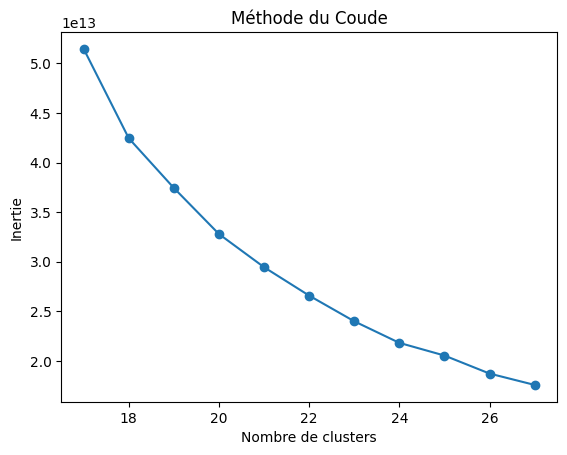

In [ ]:
# Tracer l'inertie pour observer le coude
plt.plot(range(nb_hydroecoregions - 5, nb_hydroecoregions + 6), inertia, marker='o')
plt.title('Méthode du Coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

On voit pas de coude : on va essayer avec le nombre de hydro eco region

## TODO CHARLOTTE : à refaire avec le nombre de clusters qu'on voit dans notre df
# -5 +5

# dupliquer les cellules et essayer (pas le faire directement ici, on conserve les 2 versions)

In [ ]:
nb_clusters = nb_hydroecoregions

df_results = df_pc_median_bio_median_1_month.copy()

# Appliquer K-Means avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=nb_clusters, random_state=42)
df_results['cluster'] = kmeans.fit_predict(df_pc_median_bio_median_1_month)

# Afficher les résultats des clusters
print(df_results[['station', 'année', 'trimestre', 'cluster']].head())


   station  année  trimestre  cluster
0  5001800   2007          3        3
1  5001800   2008          4        3
2  5001800   2009          3        3
3  5001800   2010          4        3
4  5004000   2007          3        3


In [ ]:
from sklearn.metrics import silhouette_score ## TODO ZOE EN HAUT

# Calculer le score de la silhouette
score = silhouette_score(df_pc_median_bio_median_1_month, df_results['cluster'])
print(f"Silhouette score: {score}")


Silhouette score: 0.6395745243915707


In [ ]:
# Créer un DataFrame pour calculer le pourcentage d'appartenance des stations aux clusters
cluster_distribution = df_results.groupby('station')['cluster'].value_counts(normalize=True).unstack().fillna(0) * 100
print(cluster_distribution)

cluster   0    1    2    3    4    5      6    7    8    9   ...     12   13  \
station                                                      ...               
1000274  0.0  0.0  0.0  0.0  0.0  0.0  100.0  0.0  0.0  0.0  ...    0.0  0.0   
1000477  0.0  0.0  0.0  0.0  0.0  0.0  100.0  0.0  0.0  0.0  ...    0.0  0.0   
1000602  0.0  0.0  0.0  0.0  0.0  0.0  100.0  0.0  0.0  0.0  ...    0.0  0.0   
1000605  0.0  0.0  0.0  0.0  0.0  0.0  100.0  0.0  0.0  0.0  ...    0.0  0.0   
1000729  0.0  0.0  0.0  0.0  0.0  0.0  100.0  0.0  0.0  0.0  ...    0.0  0.0   
...      ...  ...  ...  ...  ...  ...    ...  ...  ...  ...  ...    ...  ...   
6999125  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  ...  100.0  0.0   
6999137  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  ...  100.0  0.0   
6999153  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  ...  100.0  0.0   
6999176  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  0.0  ...  100.0  0.0   
6999178  0.0  0.0  0.0  0.0  0.0  0.0   

In [ ]:
# combien de lignes dans le dataframe ?
df_pc_median_bio_median_1_month.shape[0]

38101

In [ ]:
# combien de stations différentes ?
df_pc_median_bio_median_1_month['station'].nunique()

8268

In [ ]:
stations_100_percent = cluster_distribution[cluster_distribution.eq(100.0).sum(axis=1) == 1]
print("Stations à 100% dans un seul cluster :")
print(stations_100_percent.shape)

Stations à 100% dans un seul cluster :
(8268, 22)


Toutes les stations sont donc à 100% dans un cluster : super !

In [ ]:
stations_multicluster = cluster_distribution[cluster_distribution.eq(100).sum(axis=1) > 1]
print("Stations réparties dans plusieurs clusters :")
print(stations_multicluster.shape)

Stations réparties dans plusieurs clusters :
(0, 22)


### Visualiser sur la map les stations dans leur cluster respectif avec une couleur


## TODO ensuite les voir dans les hydroecoregions


In [ ]:
# join df_results avec df_stations pour récupérer CoordXStationMesureEauxSurface, CoordYStationMesureEauxSurface
df_coord_stations = df_stations.copy()
df_coord_stations = df_coord_stations[['station', 'CoordXStationMesureEauxSurface', 'CoordYStationMesureEauxSurface']]
df_coord_stations['station'] = df_coord_stations['station'].astype(str)
print(df_coord_stations.dtypes)
df_results_coord = pd.merge(df_results, df_coord_stations, on='station', how='inner')
df_results_coord.head(5)

station                            object
CoordXStationMesureEauxSurface    float64
CoordYStationMesureEauxSurface    float64
dtype: object


,station,année,Ammonium - Eau,Azote Kjeldahl - Eau,Carbone Organique - Eau,Conductivité à 25°C - Eau,Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau,Matières en suspension - Eau,Nitrates - Eau,Nitrites - Eau,...,Phosphore total - Eau,Potentiel en Hydrogène (pH) - Eau,Taux de saturation en oxygène - Eau,Température de l'Eau - Eau,Turbidité Formazine Néphélométrique - Eau,I2M2,trimestre,cluster,CoordXStationMesureEauxSurface,CoordYStationMesureEauxSurface
0,5001800,2007,0.040,1.0,3.5,765.0,0.50,3.0,36.2,0.090,...,0.05,7.90,89.0,18.60,8.998637,0.3004,3,3,399856.0,6531980.0
1,5001800,2008,0.045,1.0,4.1,826.0,0.85,11.0,34.3,0.075,...,0.05,8.15,84.0,14.25,8.998637,0.3848,4,3,399856.0,6531980.0
2,5001800,2009,0.020,1.0,2.2,736.0,1.00,6.0,37.9,0.070,...,0.07,8.00,83.0,20.60,8.998637,0.5756,3,3,399856.0,6531980.0
3,5001800,2010,0.020,1.0,2.7,731.0,0.90,3.4,39.3,0.070,...,0.05,7.84,88.0,15.80,8.998637,0.5684,4,3,399856.0,6531980.0
4,5005350,2007,0.030,1.0,2.4,632.0,0.75,5.5,30.2,0.085,...,0.14,7.90,73.0,14.70,8.998637,0.4851,4,3,450151.0,6572920.0


C:\Users\charl\AppData\Local\Temp\ipykernel_26696\4015213727.py:5: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



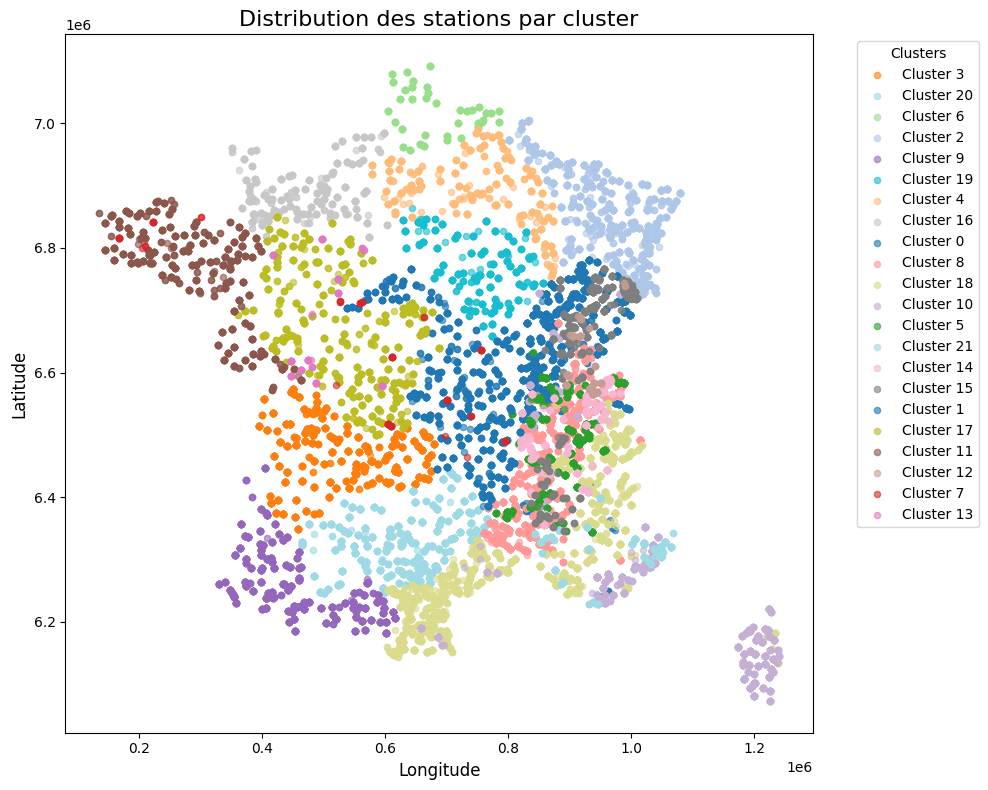

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

unique_clusters = df_results_coord['cluster'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_clusters))  # Utilise un colormap pour gérer les couleurs

plt.figure(figsize=(10, 8))

# Trace chaque station, colorée par son cluster
for cluster in unique_clusters:
    # Sélectionne les stations appartenant à ce cluster
    cluster_data = df_results_coord[df_results_coord['cluster'] == cluster]
    plt.scatter(
        cluster_data['CoordXStationMesureEauxSurface'], 
        cluster_data['CoordYStationMesureEauxSurface'], 
        c=[colors(cluster)],  # Attribue une couleur à chaque cluster
        label=f"Cluster {cluster}",  # Légende pour chaque cluster
        s=20,  # Taille des marqueurs
        alpha=0.6  # Transparence
    )

# Ajouter des titres et des légendes
plt.title('Distribution des stations par cluster', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

# Afficher la carte
plt.tight_layout()  # Pour éviter que la légende dépasse
plt.show()



C:\Users\charl\AppData\Local\Temp\ipykernel_26696\3149742656.py:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



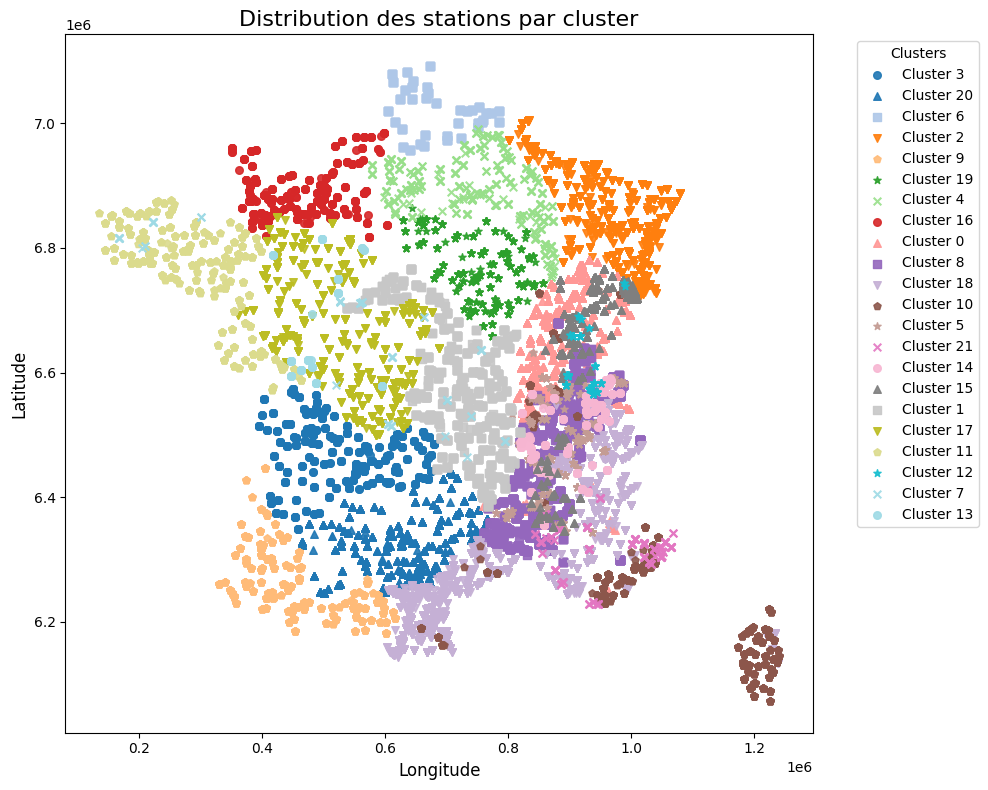

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Récupère les clusters uniques
unique_clusters = df_results_coord['cluster'].unique()

colors = plt.cm.get_cmap('tab20', len(unique_clusters))  # 'tab20' pour plus de 10 couleurs
markers = ['o', '^', 's', 'v', 'p', '*', 'x']  # Liste des différentes formes de marqueurs
plt.figure(figsize=(10, 8))

for idx, cluster in enumerate(unique_clusters):
    cluster_data = df_results_coord[df_results_coord['cluster'] == cluster]
    
    color = colors(idx)
    marker = markers[idx % len(markers)]  # Assure-toi d'avoir assez de formes, sinon les répète

    plt.scatter(
        cluster_data['CoordXStationMesureEauxSurface'], 
        cluster_data['CoordYStationMesureEauxSurface'], 
        c=[color],  # Attribue une couleur à chaque cluster
        marker=marker,  # Attribue une forme différente à chaque cluster
        label=f"Cluster {cluster}",  # Légende pour chaque cluster
        s=30,  # Taille des marqueurs
        alpha=0.9  # Transparence
    )

plt.title('Distribution des stations par cluster', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  
plt.show()


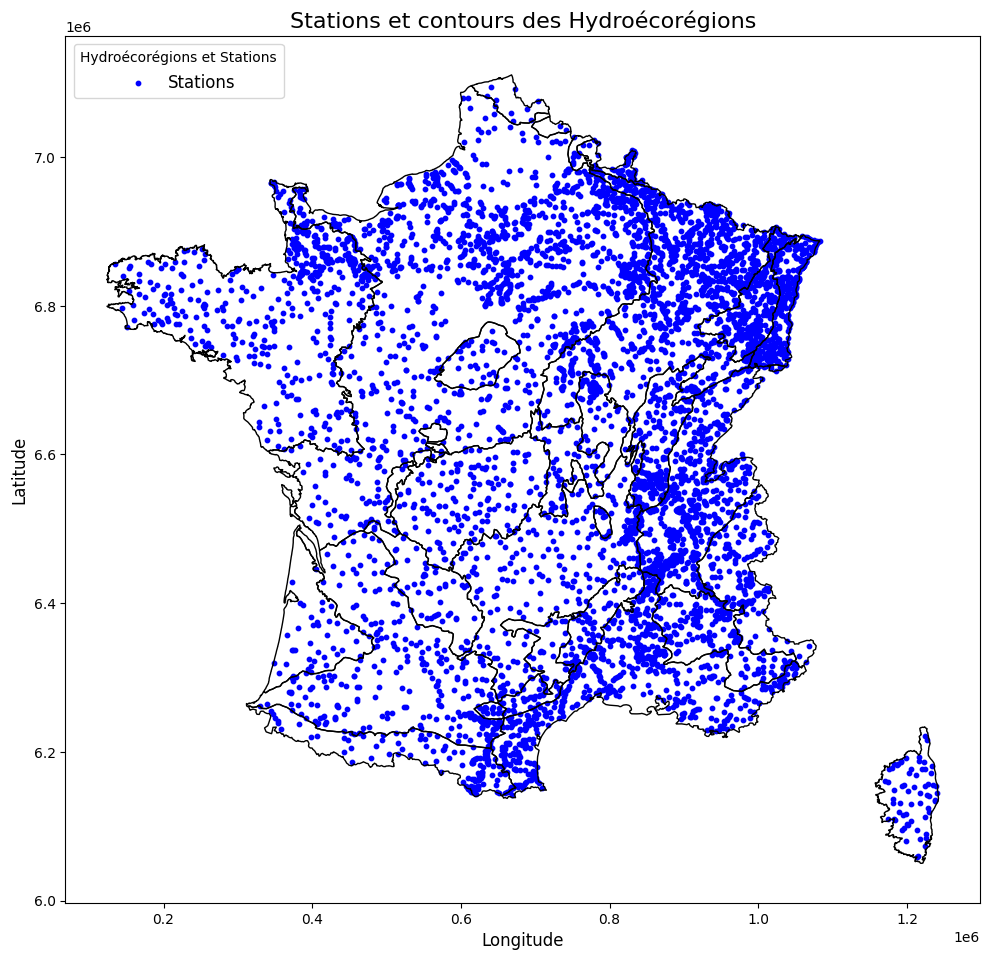

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import geometry as geom

# Projection Lambert 93
crs_lambert = 'PROJCS["RGF_1993_Lambert_93",GEOGCS["GCS_RGF_1993",DATUM["D_RGF_1993",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",700000.0],PARAMETER["False_Northing",6600000.0],PARAMETER["Central_Meridian",3.0],PARAMETER["Standard_Parallel_1",49.0],PARAMETER["Standard_Parallel_2",44.0],PARAMETER["Latitude_Of_Origin",46.5],UNIT["Meter",1.0]]'

x_col = 'CoordXStationMesureEauxSurface'
y_col = 'CoordYStationMesureEauxSurface'

# Créer un GeoDataFrame pour les stations avec des points en Lambert 93
carto_i2m2 = gpd.GeoDataFrame(
    df_stations,
    crs=crs_lambert,
    geometry=gpd.GeoSeries(df_stations.apply(lambda x: geom.Point(x[x_col], x[y_col]), axis=1))
)

# Charger les hydroécorégions et les convertir en Lambert 93
HER_lambert = df_hydroregions.to_crs(crs_lambert)

# Réaliser une jointure spatiale entre stations et hydroécorégions
HER_stations = carto_i2m2.sjoin(HER_lambert, predicate='within')

# Préparer la figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Tracer uniquement les contours des hydroécorégions
HER_lambert.boundary.plot(ax=ax, color='black', linewidth=1)

# Tracer tous les points de `df_stations` dans une seule couleur
carto_i2m2.plot(ax=ax, color='blue', markersize=10, label='Stations')

# Ajouter une légende
ax.legend(loc='upper left', fontsize='large', title='Hydroécorégions et Stations')

# Ajouter un titre et des labels
plt.title('Stations et contours des Hydroécorégions', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()


C:\Users\charl\AppData\Local\Temp\ipykernel_26696\1741341952.py:26: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



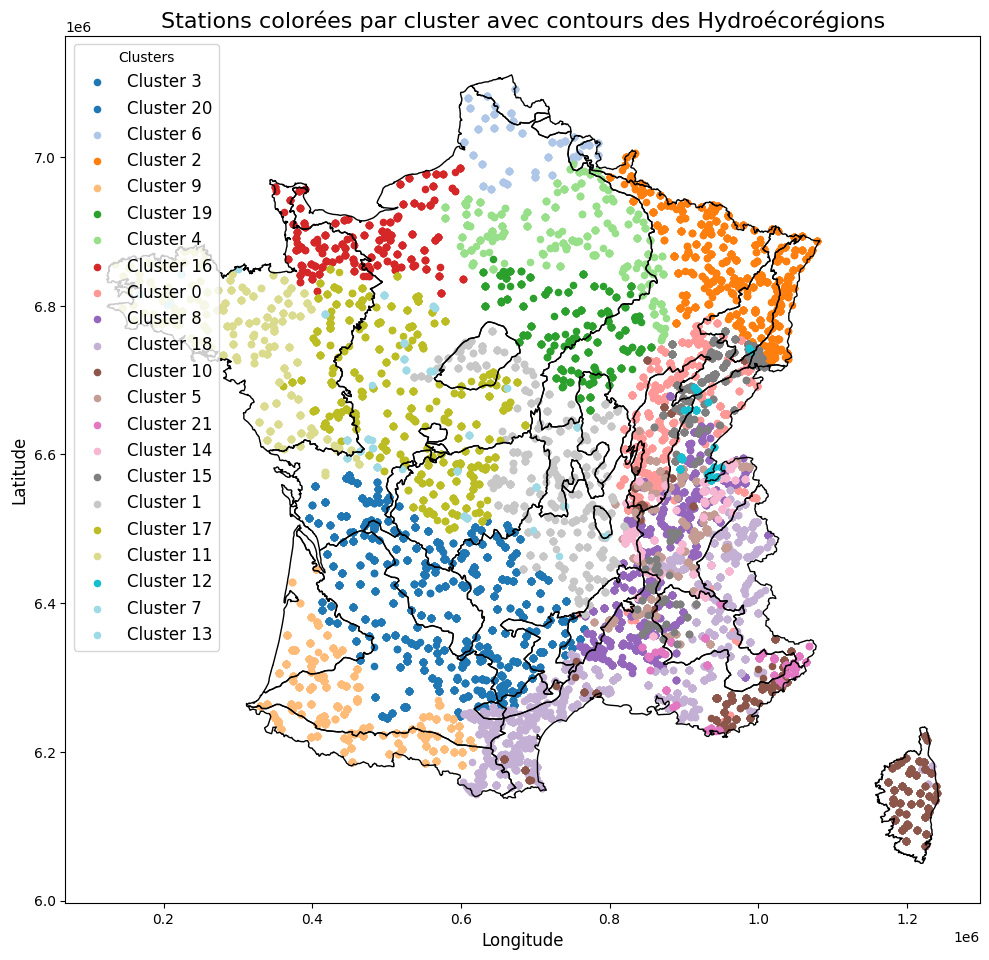

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import geometry as geom
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Projection Lambert 93
crs_lambert = 'PROJCS["RGF_1993_Lambert_93",GEOGCS["GCS_RGF_1993",DATUM["D_RGF_1993",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",700000.0],PARAMETER["False_Northing",6600000.0],PARAMETER["Central_Meridian",3.0],PARAMETER["Standard_Parallel_1",49.0],PARAMETER["Standard_Parallel_2",44.0],PARAMETER["Latitude_Of_Origin",46.5],UNIT["Meter",1.0]]'

x_col = 'CoordXStationMesureEauxSurface'
y_col = 'CoordYStationMesureEauxSurface'
cluster_col = 'cluster'  # Colonne contenant l'information sur les clusters

# Créer un GeoDataFrame pour les stations avec des points en Lambert 93
carto_i2m2 = gpd.GeoDataFrame(
    df_results_coord,
    crs=crs_lambert,
    geometry=gpd.GeoSeries(df_results_coord.apply(lambda x: geom.Point(x[x_col], x[y_col]), axis=1))
)

# Charger les hydroécorégions et les convertir en Lambert 93
HER_lambert = df_hydroregions.to_crs(crs_lambert)

# Préparer les couleurs pour les clusters
unique_clusters = carto_i2m2[cluster_col].unique()
cmap = cm.get_cmap('tab20', len(unique_clusters))  # Palette de couleurs
cluster_colors = {cluster: cmap(i) for i, cluster in enumerate(unique_clusters)}

# Préparer la figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Tracer uniquement les contours des hydroécorégions
HER_lambert.boundary.plot(ax=ax, color='black', linewidth=1)

# Tracer les stations colorées par cluster
for cluster, color in cluster_colors.items():
    cluster_data = carto_i2m2[carto_i2m2[cluster_col] == cluster]
    cluster_data.plot(ax=ax, color=color, markersize=20, label=f"Cluster {cluster}")

# Ajouter une légende
ax.legend(loc='upper left', fontsize='large', title='Clusters')

# Ajouter un titre et des labels
plt.title('Stations colorées par cluster avec contours des Hydroécorégions', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()


In [ ]:
# TODO : interpréter les clusters

In [ ]:


# ensuite refaire avec moyenne, puis autre décalage (genre juste copier, coller, peut etre créer des fonctions, on voit qui ressemble le plus...)

TODO : on essaye d'autres méthodes pour trouver le nombre de clusters

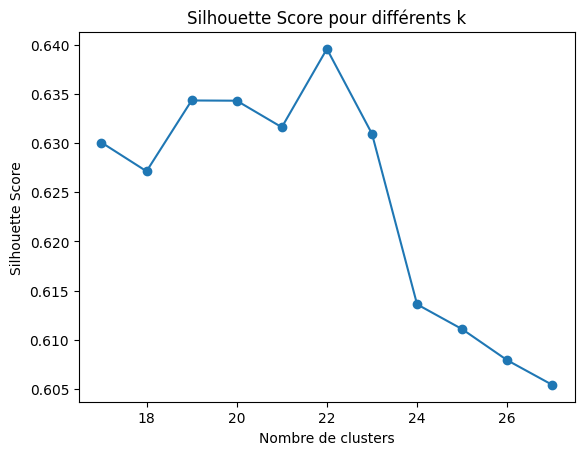

In [ ]:
from sklearn.cluster import KMeans ## TODO ZOE en haut
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

df_results_2 = df_pc_median_bio_median_1_month.copy()

sil_scores = []
for k in range(nb_hydroecoregions - 5, nb_hydroecoregions + 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    df_results_2['cluster'] = kmeans.fit_predict(df_pc_median_bio_median_1_month)
    sil_score = silhouette_score(df_pc_median_bio_median_1_month, df_results_2['cluster'])
    sil_scores.append(sil_score)

plt.plot(range(nb_hydroecoregions - 5, nb_hydroecoregions + 6), sil_scores, marker='o')
plt.title('Silhouette Score pour différents k')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()


## TODO : revoir ça

In [ ]:
# TODO : afficher les clusters sur la carte
# TODO puis afficher quels attrbiuts

In [ ]:
# TODO ZOE : traitements des données manquantes ?

# K-Means Clustering

# DTW ?

## Visualisation des clusters

In [ ]:


n_components = # TODO ZOE combien d'hydroecroegions

SyntaxError: invalid syntax (259917344.py, line 1)

In [ ]:
# TODO CHARLOTTE : si pas de données pour toutes les hydroecoregions re clustering
# avec le nombre d'hydroecoregions représentées

# Conclusion

## TODO

rappel de tout ce qu'on a fait

rappel 